<div style="text-align: right"> - last read : 2019. 06. 2 </div>


## Sound Source Location (방위각 추정) and VAD as Multi-task learning
- Based on STFT magnitude and phase.  
- 2 Models: 
  - 2D CNN for feature extraction -> GRU 
  - 2D CNN for feature extraction ->1D CNN

### Inputs : 
- Input : Magnitude and Phase from two stereo channels : So there are 4 feature maps. The first freq bin is not used.
- Magnitude, Phase : Basic Magnitude and Phase with STFT. 
- STFT : n_fft=1024, hop = 512 with sr=44100.  So each frame is 23.2 msec duration. Hop is 11.6 msec. With 100 consecutive frames with the hop, the duration is `1024/44100 + 99 * (512/44100) = 1.1726 sec `
- Stack 4 feature maps.  


In [1]:
# Common imports
import numpy as np
import pandas as pd
import os, sys, glob  
import tensorflow as tf

import librosa
import librosa.display

# To plot pretty figures
# import matplotlib
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.style.use('ggplot')
# plt.rcParams['axes.labelsize'] = 14
# plt.rcParams['xtick.labelsize'] = 12
# plt.rcParams['ytick.labelsize'] = 12

def reset_graph(seed=42):
    tf.reset_default_graph() 
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
def reset_keras_session(seed=42):
    tf.keras.backend.clear_session()
    tf.set_random_seed(seed)
    np.random.seed(seed)

import warnings
warnings.filterwarnings("ignore")   # To rid of warnings 

if sys.platform == 'win32':   # if windows 
    home = os.path.join('D:', os.sep, 'hblee')   # d:\hblee
    data_repo = os.path.join('D:', os.sep, 'Data_Repo_Win')   # d:\Data_Repo_Win
elif sys.platform == "linux" or sys.platform == "linux2" :    # if linux 
    home = os.path.expanduser("~")   # home = os.getenv("HOME")
    data_repo = os.path.join(home, 'Data_Repo')
    
sys.path.append(os.path.join(home, 'Google_Sync', 'Dev_Exercise', 'utils'))
# from tf_utils import *
    
from tensorflow import keras 
keras.__version__, tf.VERSION

('2.2.4-tf', '1.13.1')

In [6]:
'''
samples : audio samples(files).  50 of them 
samples_vad_seg : samples segmented as to voice region (1) and non-voice region (0) 

samples and samples_vad_seg should be aligned.  
'''

sample_data_repo1= os.path.join(home, 'Downloads','t3_audio')
sample_data_repo2= os.path.join(home, 'Downloads','audio','20도')
sample_data_repo3= os.path.join(home, 'Downloads','audio','40도')
sample_data_repo4= os.path.join(home, 'Downloads','audio','80도')
sample_data_repo5= os.path.join(home, 'Downloads','audio','100도')
sample_data_repo6= os.path.join(home, 'Downloads','audio','140도')
sample_data_repo7= os.path.join(home, 'Downloads','audio','160도')

samples1 = glob.glob(os.path.join(sample_data_repo1, '**', '*wav'), recursive=True)
samples2 = glob.glob(os.path.join(sample_data_repo2, '**', '*wav'), recursive=True)
samples3 = glob.glob(os.path.join(sample_data_repo3, '**', '*wav'), recursive=True)
samples4 = glob.glob(os.path.join(sample_data_repo4, '**', '*wav'), recursive=True)
samples5 = glob.glob(os.path.join(sample_data_repo5, '**', '*wav'), recursive=True)
samples6 = glob.glob(os.path.join(sample_data_repo6, '**', '*wav'), recursive=True)
samples7 = glob.glob(os.path.join(sample_data_repo7, '**', '*wav'), recursive=True)


samples1 = sorted(samples1)
samples2 = sorted(samples2)
samples3 = sorted(samples3)
samples4 = sorted(samples4)
samples5 = sorted(samples5)
samples6 = sorted(samples6)
samples7 = sorted(samples7)



sample_vad_seg_repo1 = os.path.join(home, 'Downloads','t3_audio_label') 
sample_vad_seg_repo2 = os.path.join(home, 'Downloads','binary_segment','20도') # 적절하게 변경 필요 
sample_vad_seg_repo3 = os.path.join(home, 'Downloads','binary_segment','40도')
sample_vad_seg_repo4 = os.path.join(home, 'Downloads','binary_segment','80도')
sample_vad_seg_repo5 = os.path.join(home, 'Downloads','binary_segment','100도')
sample_vad_seg_repo6 = os.path.join(home, 'Downloads','binary_segment','140도')
sample_vad_seg_repo7 = os.path.join(home, 'Downloads','binary_segment','160도')


samples_vad_seg1 = glob.glob(os.path.join(sample_vad_seg_repo1, '**', '*[npy|npz]'), recursive=True)
samples_vad_seg2 = glob.glob(os.path.join(sample_vad_seg_repo2, '**', '*[npy|npz]'), recursive=True)
samples_vad_seg3 = glob.glob(os.path.join(sample_vad_seg_repo3, '**', '*[npy|npz]'), recursive=True)
samples_vad_seg4 = glob.glob(os.path.join(sample_vad_seg_repo4, '**', '*[npy|npz]'), recursive=True)
samples_vad_seg5 = glob.glob(os.path.join(sample_vad_seg_repo5, '**', '*[npy|npz]'), recursive=True)
samples_vad_seg6 = glob.glob(os.path.join(sample_vad_seg_repo6, '**', '*[npy|npz]'), recursive=True)
samples_vad_seg7 = glob.glob(os.path.join(sample_vad_seg_repo7, '**', '*[npy|npz]'), recursive=True)


samples_vad_seg1 = sorted(samples_vad_seg1)
samples_vad_seg2 = sorted(samples_vad_seg2)
samples_vad_seg3 = sorted(samples_vad_seg3)
samples_vad_seg4 = sorted(samples_vad_seg4)
samples_vad_seg5 = sorted(samples_vad_seg5)
samples_vad_seg6 = sorted(samples_vad_seg6)
samples_vad_seg7 = sorted(samples_vad_seg7)



#  Checking 
#print('samples: ', len(samples), samples[25])
#print('samples segmented: ', len(samples_vad_seg), samples_vad_seg[25])   

In [7]:
samples = []
samples.append(samples1)
samples.append(samples2)
samples.append(samples3)
samples.append(samples4)
samples.append(samples5)
samples.append(samples6)
samples.append(samples7)

samples_vad_seg = []
samples_vad_seg.append(samples_vad_seg1)
samples_vad_seg.append(samples_vad_seg2)
samples_vad_seg.append(samples_vad_seg3)
samples_vad_seg.append(samples_vad_seg4)
samples_vad_seg.append(samples_vad_seg5)
samples_vad_seg.append(samples_vad_seg6)
samples_vad_seg.append(samples_vad_seg7)


In [8]:
samples = list(np.concatenate(samples))
samples_vad_seg = list(np.concatenate(samples_vad_seg))

In [9]:
no_20 = 50 + len(samples2)
no_40 = no_20 + len(samples3)
no_80 = no_40 + len(samples4)
no_100 = no_80 + len(samples5)
no_140 = no_100 + len(samples6)
no_160 = no_140 + len(samples7)


# train data set 만들기

In [40]:
def mag_phase(file_path, sr=48000, n_fft=1024, hop_length=512, db=False, n_mels=50) :
    """
    stft의 magnitude와 phase 리턴.  첫번째 bin 제거 
    input : file path to an audio sample.  Assumed stereo. 
    """
    audio, sr = librosa.load(file_path, sr=sr, mono=False)   # 원래의 sr, stereo
    DL = librosa.stft(audio[0], n_fft=n_fft, hop_length=hop_length)
    DL_mag, DL_phase = librosa.magphase(DL)
    
    DR = librosa.stft(audio[1], n_fft=n_fft, hop_length=hop_length)
    DR_mag, DR_phase = librosa.magphase(DR)
    
    if db :
        DL_mag = librosa.core.amplitude_to_db(DL_mag)
        DR_mag = librosa.core.amplitude_to_db(DR_mag)
     
    # rescale the right magnitudes w.r.t left channel magnitude 
    avg = DL_mag.mean()     
    stdv = DL_mag.std()
    DL_mag = (DL_mag - avg)/stdv
    DR_mag = (DR_mag - avg)/stdv
    
    # return( (DL_mag, np.angle(DL_phase)), (DR_mag, np.angle(DR_phase)) )
    return( (DL_mag[1:, :], np.angle(DL_phase)[1:, :]), (DR_mag[1:, :], np.angle(DR_phase)[1:, :]) )

In [41]:
def generatio_tensor_instances(array_2d, dest_path, seq_len, hop, label):
    """
    array_2d : ndarray.  STFT magnitude or phase.
    dest_path : file path
    seq_len : number of frames in an instance.
    label : segmented labels.  0 and 1's. The same length as original wav file of the audio sample. 
    """
    row_size, col_size = array_2d.shape[0], array_2d.shape[1]
    ratio = len(label)/col_size  # ratio : how many data points per frame 
    stack_array = []    # 4D tensor that will hold the instances
    label_array = []

    j=0
    while j <= (col_size - (seq_len+1)): 
        context_frame = array_2d[:, j:(j+seq_len)]
        # seg_label = round( label[int(j*ratio):int((j+seq_len)*ratio)].mean() ) 
        threshold = 0.5  # if greater than the threshold, then speech 
        seg_label = 1 if label[int(j*ratio):int((j+seq_len)*ratio)].mean() > threshold else 0

#         # store the instances
#         dest_path_ext = ''.join([dest_path, '_', str(j)])
#         os.makedirs(os.path.dirname(dest_path_ext), exist_ok=True)

#         np.savez(dest_path_ext, spectrogram = context_frame,
#                  label=seg_label)
        
        stack_array.append(context_frame[:,:,np.newaxis])   # make context_frame to 3d tensor & append 
        label_array.append(seg_label)
            
        j = j+hop
        
    return np.stack(stack_array, axis=0), label_array

In [42]:
no_samples = len(samples) 

mag_L_instances = []    # elements are ndarrays
mag_R_instances = []
phase_L_instances = []
phase_R_instances = []
label_instances = []         # elements are lists

for i in range(0, no_samples):
    voice_noise_label = np.load(samples_vad_seg[i])
    if('npy' in samples_vad_seg[i].split('/')[-1]):
        label = voice_noise_label[0]        # use the left channel label.  this take care of 0 degree problem
    else:                                   # npz file
        label = voice_noise_label["label"]    
    (mag_L, phase_L), (mag_R, phase_R) = mag_phase(samples[i], db=True)
    
    # generate instances with 1.16 sec duration (100 frames), at every 0.116 sec apart (10 hops)
    voice_dest_path = os.path.join("mag", "Left", str(i))
    mag_L_instances_sub, _ = generatio_tensor_instances(mag_L, voice_dest_path, 100, 10, label)
    
    voice_dest_path = os.path.join("mag", "Right", str(i))
    mag_R_instances_sub, _ = generatio_tensor_instances(mag_R, voice_dest_path, 100, 10, label)
    
    voice_dest_path = os.path.join("phase", "Left", str(i))
    phase_L_instances_sub, _ = generatio_tensor_instances(phase_L, voice_dest_path, 100, 10, label)
    
    voice_dest_path = os.path.join("phase", "Right", str(i))
    phase_R_instances_sub, label_sub = generatio_tensor_instances(phase_R, voice_dest_path, 100, 10, label)
    
    mag_L_instances.append(mag_L_instances_sub)
    mag_R_instances.append(mag_R_instances_sub)
    phase_L_instances.append(phase_L_instances_sub)
    phase_R_instances.append(phase_R_instances_sub)
    
    label_instances.append(np.array(label_sub))
    

print(len(mag_L_instances), len(phase_R_instances), len(label_instances))

mag_L_instances[0].shape, phase_R_instances[0].shape, label_instances[0].shape
# the first sample produced 15 instances.  

315 315 315


((17, 512, 100, 1), (17, 512, 100, 1), (17,))

In [43]:
stacked_instances = []

for i in range(0, no_samples):
    concat_tensor = np.concatenate([mag_L_instances[i], phase_L_instances[i], 
                                    mag_R_instances[i], phase_R_instances[i]], axis = -1)
    stacked_instances.append(concat_tensor)
    
len(stacked_instances), stacked_instances[0].shape    # L, R magnitudes and phases are stacked.

(315, (17, 512, 100, 4))

`stacked_instances` has 50 samples, where each sample holds ndarray instances produced from the corresponding audio sample

#### Checking :

In [44]:
# the total number of instances generated:
total = 0
for i in range(0, no_samples):
    total = total + stacked_instances[i].shape[0]
print("Numer of the instances generated : : ",total) 

# the ratio of instances with 0 or 1 label.  76% of the instances are labeled 1 (voice)
ave=[]
for sample in label_instances:
    ave.append(np.mean(sample))
print("Percentage of voice instances: ", np.mean(ave) )

# Check the shapes 
for i in range(0, no_samples, 5):
    print(stacked_instances[i].shape, label_instances[i].shape)
    

Numer of the instances generated : :  30862
Percentage of voice instances:  0.4615719270952825
(17, 512, 100, 4) (17,)
(13, 512, 100, 4) (13,)
(14, 512, 100, 4) (14,)
(27, 512, 100, 4) (27,)
(5, 512, 100, 4) (5,)
(9, 512, 100, 4) (9,)
(21, 512, 100, 4) (21,)
(12, 512, 100, 4) (12,)
(43, 512, 100, 4) (43,)
(17, 512, 100, 4) (17,)
(28, 512, 100, 4) (28,)
(28, 512, 100, 4) (28,)
(179, 512, 100, 4) (179,)
(179, 512, 100, 4) (179,)
(28, 512, 100, 4) (28,)
(28, 512, 100, 4) (28,)
(179, 512, 100, 4) (179,)
(28, 512, 100, 4) (28,)
(179, 512, 100, 4) (179,)
(28, 512, 100, 4) (28,)
(28, 512, 100, 4) (28,)
(28, 512, 100, 4) (28,)
(28, 512, 100, 4) (28,)
(28, 512, 100, 4) (28,)
(28, 512, 100, 4) (28,)
(28, 512, 100, 4) (28,)
(743, 512, 100, 4) (743,)
(179, 512, 100, 4) (179,)
(28, 512, 100, 4) (28,)
(28, 512, 100, 4) (28,)
(179, 512, 100, 4) (179,)
(743, 512, 100, 4) (743,)
(179, 512, 100, 4) (179,)
(28, 512, 100, 4) (28,)
(28, 512, 100, 4) (28,)
(179, 512, 100, 4) (179,)
(28, 512, 100, 4) (28,)
(

To this point, the `label_instances` showed the labels for `voice (1) and non_voice (0)` instances.  Now transform the `label_instances` to show the **class labels of the voice directions.**

#### noise와 voice 방향에 따라 labeling
- noise : 0                 
- 0도 : 1  , -90  
- 20도 : 2 ,  -70
- 40도 : 3 , -50
- 60도 : 4 , -30
- 80도 : 5 , -10
- 100도 : 6 , 10
- 120도 : 7 , 30
- 140도 : 8 , 50
- 160도 : 9 , 70
- 180도 :10  , 90

In [45]:
import copy
vad_label_instances = copy.deepcopy(label_instances)

In [46]:
for i in range(0,12): #0
    for j in range(0, len(label_instances[i])):
        if(label_instances[i][j] == 1):
            label_instances[i][j] = 1
            
for i in range(12,25): #60도
    for j in range(0, len(label_instances[i])):
        if(label_instances[i][j] == 1):
            label_instances[i][j] = 4
            
for i in range(25,38): #120도
    for j in range(0, len(label_instances[i])):
        if(label_instances[i][j] == 1):
            label_instances[i][j] = 7
            
for i in range(38,50): #180도
    for j in range(0, len(label_instances[i])):
        if(label_instances[i][j] == 1):
            label_instances[i][j] = 10
            
for i in range(50,no_20): #20도
    for j in range(0, len(label_instances[i])):
        if(label_instances[i][j] == 1):
            label_instances[i][j] = 2
                       
for i in range(no_20,no_40): #40도
    for j in range(0, len(label_instances[i])):
        if(label_instances[i][j] == 1):
            label_instances[i][j] = 3
            
for i in range(no_40,no_80): #80도
    for j in range(0, len(label_instances[i])):
        if(label_instances[i][j] == 1):
            label_instances[i][j] = 5
            
for i in range(no_80,no_100): #100도
    for j in range(0, len(label_instances[i])):
        if(label_instances[i][j] == 1):
            label_instances[i][j] = 6
            
for i in range(no_100,no_140): #140도
    for j in range(0, len(label_instances[i])):
        if(label_instances[i][j] == 1):
            label_instances[i][j] = 8

for i in range(no_140,no_160): #160도
    for j in range(0, len(label_instances[i])):
        if(label_instances[i][j] == 1):
            label_instances[i][j] = 9
                        

# label_instances

We have 822 instances. And we have labeled them into 5 classes.  Let's see how those labels are distributed.

In [14]:
instances_labels = np.array([])
for audio_clip in label_instances:
    instances_labels = np.hstack([instances_labels, audio_clip])
   
pd.Series(instances_labels).value_counts().sort_index()   

0.0     25449
1.0       143
2.0       655
3.0       698
4.0       150
5.0       830
6.0       910
7.0       215
8.0       733
9.0       901
10.0      178
dtype: int64

#### `non-voice` instances (Class-0) have the largest percentage

### Now we have `stacked_instances & label_instances`
- `stacked_instances` : list of 50 ndarrays.  Each ndarray has instances of the audio sample
- `label_instances` ; list of 50 ndarrays denoting sample's class labels

## Construct `train and validation set` split.
- Out of 50 audio samples, we will take 40 samples for training set, and the remaining to the validation set.  Try to mix them evenly.
- Note that `stacked_instances` indices has : 0~11(Class-1), 12~24(Class-2), 23~37(Class-3), 38~49(Class-4) and Class-0 is assigned to the non_voice  

In [10]:
total_instances_tensors = np.load('total_instances_tensors.npy', allow_pickle=True)
total_label_tensors = np.load('total_label_tensors.npy', allow_pickle=True)
total_vad_label_tensors = np.load('total_vad_label_tensors.npy', allow_pickle=True)

In [11]:
# transform the list to ndarray
#total_instances_tensors = np.array(stacked_instances)  
#total_label_tensors = np.array(label_instances)
#total_vad_label_tensors = np.array(vad_label_instances)

# randomly choose indices to be split to training and validation set
np.random.seed(19)   # 19, 7, 5, 113, 34

no_samples = len(samples) 
idx = np.random.permutation(no_samples)

'''
c1 = 0
c2 = 0
c3 = 0
c4 = 0

for i in idx[-10:]:
    if 0 <= i <= 11:
        c1 = c1 + 1
    elif 12 <= i <= 24 :
        c2 = c2 + 1
    elif 25 <= i <= 37 :
        c3 = c3 + 1
    elif 38 <= i :
        c4 = c4 + 1

print("Valid set distr.: Class-1: %d,  Class-2: %d,  Class-3: %d,  Class-4: %d\n" % (c1, c2, c3, c4))
'''

# Shuffle 
X = total_instances_tensors[[idx]]   # Shuffle the data using fancy indexing
y = total_label_tensors[[idx]]
y_vad = total_vad_label_tensors[[idx]]

train_index = round(no_samples * 0.8)  

# Test 
for i in range(0, no_samples, 10):
    print(X[i].shape, y[i].shape)
    
# Split 
X_train = np.concatenate(X[:train_index], axis=0)
y_train = np.concatenate(y[:train_index], axis=0)
vad_train = np.concatenate(y_vad[:train_index], axis=0)

X_val = np.concatenate(X[train_index: ], axis=0)
y_val = np.concatenate(y[train_index: ], axis=0)
vad_val= np.concatenate(y_vad[train_index: ], axis=0)

print()
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

# Convert scalar y's to One-Hot.  'y_val_vad' is not needed because it is binary classification 
y_train = keras.utils.to_categorical(y_train, 11)    # 5-Classes classification 
y_val = keras.utils.to_categorical(y_val, 11)

(21, 512, 100, 4) (21,)
(179, 512, 100, 4) (179,)
(28, 512, 100, 4) (28,)
(179, 512, 100, 4) (179,)
(28, 512, 100, 4) (28,)
(179, 512, 100, 4) (179,)
(28, 512, 100, 4) (28,)
(5, 512, 100, 4) (5,)
(179, 512, 100, 4) (179,)
(28, 512, 100, 4) (28,)
(28, 512, 100, 4) (28,)
(28, 512, 100, 4) (28,)
(28, 512, 100, 4) (28,)
(28, 512, 100, 4) (28,)
(179, 512, 100, 4) (179,)
(28, 512, 100, 4) (28,)
(179, 512, 100, 4) (179,)
(179, 512, 100, 4) (179,)
(179, 512, 100, 4) (179,)
(28, 512, 100, 4) (28,)
(28, 512, 100, 4) (28,)
(13, 512, 100, 4) (13,)
(28, 512, 100, 4) (28,)
(13, 512, 100, 4) (13,)
(28, 512, 100, 4) (28,)
(17, 512, 100, 4) (17,)
(28, 512, 100, 4) (28,)
(179, 512, 100, 4) (179,)
(179, 512, 100, 4) (179,)
(28, 512, 100, 4) (28,)
(179, 512, 100, 4) (179,)
(28, 512, 100, 4) (28,)

(25400, 512, 100, 4) (25400,)
(5462, 512, 100, 4) (5462,)



# 모델1.  (2D CNN + Bidirectional GRU) based Network 2output

In [16]:
from tensorflow.keras.layers import TimeDistributed, Bidirectional
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Input, Flatten, Dropout
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
reset_keras_session(100)

if 'model' in locals():
    del model
    
input_spectrogram = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

conv_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_spectrogram)
conv_1_pool = MaxPooling2D((3, 2))(conv_1)

conv_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_1_pool)
conv_2_pool = MaxPooling2D((3, 2))(conv_2)

conv_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_2_pool)
conv_3_pool = MaxPooling2D((3, 2))(conv_3)

conv_4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_3_pool)
conv_4_pool = MaxPooling2D((3, 2))(conv_4)

shape_conv_4_pool = conv_4_pool.get_shape().as_list()    # (None, height, width, channel)
conv_5 = Conv2D(128, (shape_conv_4_pool[1], 1), padding='valid', activation='relu')(conv_4_pool)
# 앞의 conv_5 필터 수를 256 으로 늘리면 학습이 잘 진행되지 않음 

shape_conv_5 = conv_5.get_shape().as_list()
reshaped = layers.Reshape((shape_conv_5[2], shape_conv_5[3]))(conv_5)   # reshape to (timesteps, features) explicitly 
bgru = Bidirectional(layers.GRU(units=128))(reshaped)  # GRU units 의 수를 늘리면?  

fc1 = layers.Dense(32, activation='relu')(bgru)
fc1_drop = Dropout(0.5)(fc1)

vad_out = layers.Dense(1, activation='sigmoid', name='vad_out')(fc1_drop)
class_out = layers.Dense(11, activation='softmax', name='class_out')(fc1_drop)



model = models.Model(inputs=input_spectrogram, outputs=[vad_out, class_out])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 100, 4)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 100, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 170, 50, 64)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 170, 50, 64)  36928       max_pooling2d[0][0]              
__________________________________________________________________________________________________
max_poolin

In [18]:
from tensorflow.keras.utils import multi_gpu_model
model = multi_gpu_model(model, gpus=8)

model.compile(optimizer ='adam',loss={'vad_out':'binary_crossentropy','class_out':'categorical_crossentropy'}, 
              metrics ={'vad_out':'acc','class_out':'acc'})

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
                  keras.callbacks.ModelCheckpoint(filepath='Best_SSL_STFT_2DConv_RNN_2output.h5', 
                                                  monitor='val_loss', save_best_only=True, mode='auto'),
                  keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                       factor=0.1, patience=50)]

history = model.fit(X_train, [vad_train, y_train],
                    epochs=150, batch_size=64, 
                    callbacks=callbacks_list,
                    validation_data=(X_val, [vad_val, y_val]),
                    shuffle=True)

Train on 25400 samples, validate on 5462 samples
Epoch 1/150
25400/25400 [==============================] - 87s 3ms/sample - loss: 0.7343 - vad_out_loss: 0.1803 - class_out_loss: 0.5540 - vad_out_acc: 0.9297 - class_out_acc: 0.8287 - val_loss: 0.4833 - val_vad_out_loss: 0.0446 - val_class_out_loss: 0.4387 - val_vad_out_acc: 0.9962 - val_class_out_acc: 0.8330
Epoch 2/150
25400/25400 [==============================] - 76s 3ms/sample - loss: 0.4412 - vad_out_loss: 0.0550 - class_out_loss: 0.3862 - vad_out_acc: 0.9843 - class_out_acc: 0.8506 - val_loss: 0.3947 - val_vad_out_loss: 0.0124 - val_class_out_loss: 0.3823 - val_vad_out_acc: 0.9962 - val_class_out_acc: 0.8327
Epoch 3/150
25400/25400 [==============================] - 77s 3ms/sample - loss: 0.3787 - vad_out_loss: 0.0440 - class_out_loss: 0.3346 - vad_out_acc: 0.9861 - class_out_acc: 0.8645 - val_loss: 0.3322 - val_vad_out_loss: 0.0125 - val_class_out_loss: 0.3197 - val_vad_out_acc: 0.9974 - val_class_out_acc: 0.8662
Epoch 4/150
254

25400/25400 [==============================] - 77s 3ms/sample - loss: 0.0904 - vad_out_loss: 0.0198 - class_out_loss: 0.0705 - vad_out_acc: 0.9904 - class_out_acc: 0.9704 - val_loss: 0.2284 - val_vad_out_loss: 0.0090 - val_class_out_loss: 0.2194 - val_vad_out_acc: 0.9978 - val_class_out_acc: 0.9493
Epoch 28/150
25400/25400 [==============================] - 79s 3ms/sample - loss: 0.1109 - vad_out_loss: 0.0248 - class_out_loss: 0.0861 - vad_out_acc: 0.9892 - class_out_acc: 0.9680 - val_loss: 0.2604 - val_vad_out_loss: 0.0100 - val_class_out_loss: 0.2504 - val_vad_out_acc: 0.9976 - val_class_out_acc: 0.9544
Epoch 29/150
25400/25400 [==============================] - 79s 3ms/sample - loss: 0.1078 - vad_out_loss: 0.0226 - class_out_loss: 0.0851 - vad_out_acc: 0.9896 - class_out_acc: 0.9675 - val_loss: 0.2283 - val_vad_out_loss: 0.0103 - val_class_out_loss: 0.2180 - val_vad_out_acc: 0.9960 - val_class_out_acc: 0.9453
Epoch 30/150
25400/25400 [==============================] - 77s 3ms/sample

In [33]:
import sklearn.metrics 
best_model = keras.models.load_model(os.path.join('.', 'Best_SSL_STFT_2DConv_RNN_2output.h5'))
vad_pred, pred = best_model.predict(X_val)

cm_vad = sklearn.metrics.confusion_matrix(vad_val, 
                                      np.where(vad_pred>=0.5, 1, 0))

cm_class = sklearn.metrics.confusion_matrix(np.argmax(y_val, axis=1), 
                                      np.argmax(pred, axis=1))

acc_vad = sklearn.metrics.accuracy_score(vad_val, 
                                      np.where(vad_pred>=0.5, 1, 0))

acc_class = sklearn.metrics.accuracy_score(np.argmax(y_val, axis=1),
                                     np.argmax(pred, axis=1))

print("Accuracy : ", acc_vad)
print(cm_vad)
print("Accuracy : ", acc_class)
print(cm_class)


Accuracy :  0.9978030025631637
[[4332   11]
 [   1 1118]]
Accuracy :  0.9434273160014647
[[4338    0    0    0    0    0    0    0    0    5]
 [   0   74   30    0   20    4    0    0    0    0]
 [   0    8  194    0    8    0    0    0    0    0]
 [  43    0    0    0    0    0    0    0    0    0]
 [   0    0    3    0   92   14    0    1    0    0]
 [  12    0    0    0   65  164    0    6    1    0]
 [   0    0    0    0    0    0    0    0    0    8]
 [   0    0    1    0    7    3    0   67   47    0]
 [   0    0    1    0    1    9    0   11  212    0]
 [   1    0    0    0    0    0    0    0    0   12]]


# 모델2. 2D CNN + 1D CNN 2output

In [21]:
reset_keras_session(100)
if 'model' in locals():
    del model
    
input_spectrogram = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

conv_1 = Conv2D(32, (3, 3), activation='relu', padding='valid')(input_spectrogram)
conv_1_pool = MaxPooling2D((3, 2))(conv_1)

conv_2 = Conv2D(64, (3, 3), activation='relu', padding='valid')(conv_1_pool)
conv_2_pool = MaxPooling2D((3, 2))(conv_2)

conv_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_2_pool)
conv_3_pool = MaxPooling2D((3, 2))(conv_3)

conv_4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_3_pool)
conv_4_pool = MaxPooling2D((3, 2))(conv_4)

shape_conv_4_pool = conv_4_pool.get_shape().as_list()    # (None, height, width, channel)
conv_5 = Conv2D(512, (shape_conv_4_pool[1], 1), padding='valid', activation='relu')(conv_4_pool)

shape_conv_5 = conv_5.get_shape().as_list()
reshaped = layers.Reshape((shape_conv_5[2], shape_conv_5[3]))(conv_5)   # reshape to (timesteps, features) explicitly 

conv_6 = Conv1D(1024, kernel_size=3, activation='relu')(reshaped)
flatten = layers.Flatten()(conv_6)

fc1 = layers.Dense(64, activation='relu')(flatten)
fc1_drop = Dropout(0.1)(fc1)

#dense_out = layers.Dense(5, activation='softmax')(fc1_drop)
vad_out = layers.Dense(1, activation='sigmoid', name='vad_out')(fc1_drop)
class_out = layers.Dense(11, activation='softmax', name='class_out')(fc1_drop)

model = models.Model(inputs=input_spectrogram, outputs=[vad_out,class_out])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 100, 4)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 510, 98, 32)  1184        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 170, 49, 32)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 168, 47, 64)  18496       max_pooling2d[0][0]              
__________________________________________________________________________________________________
max_poolin

In [22]:
from tensorflow.keras.utils import multi_gpu_model
model = multi_gpu_model(model, gpus=8)

model.compile(optimizer ='adam',loss={'vad_out':'binary_crossentropy','class_out':'categorical_crossentropy'}, 
              metrics ={'vad_out':'acc','class_out':'acc'})

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
                  keras.callbacks.ModelCheckpoint(filepath='Best_SSL_STFT_2DConv_1DCNN_2output.h5', 
                                                  monitor='val_loss', save_best_only=True, mode='auto'),
                  keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                       factor=0.1, patience=50)]

history = model.fit(X_train, [vad_train, y_train],
                    epochs=150, batch_size=64, 
                    callbacks=callbacks_list,
                    validation_data=(X_val, [vad_val, y_val]),
                    shuffle=True)

Train on 25400 samples, validate on 5462 samples
Epoch 1/150
25400/25400 [==============================] - 45s 2ms/sample - loss: 0.4759 - vad_out_loss: 0.0766 - class_out_loss: 0.3993 - vad_out_acc: 0.9682 - class_out_acc: 0.8572 - val_loss: 0.3429 - val_vad_out_loss: 0.0168 - val_class_out_loss: 0.3261 - val_vad_out_acc: 0.9956 - val_class_out_acc: 0.8739
Epoch 2/150
25400/25400 [==============================] - 44s 2ms/sample - loss: 0.2799 - vad_out_loss: 0.0310 - class_out_loss: 0.2489 - vad_out_acc: 0.9879 - class_out_acc: 0.8965 - val_loss: 0.2590 - val_vad_out_loss: 0.0118 - val_class_out_loss: 0.2472 - val_vad_out_acc: 0.9973 - val_class_out_acc: 0.9039
Epoch 3/150
25400/25400 [==============================] - 44s 2ms/sample - loss: 0.1989 - vad_out_loss: 0.0260 - class_out_loss: 0.1730 - vad_out_acc: 0.9891 - class_out_acc: 0.9259 - val_loss: 0.1794 - val_vad_out_loss: 0.0132 - val_class_out_loss: 0.1662 - val_vad_out_acc: 0.9930 - val_class_out_acc: 0.9310
Epoch 4/150
254

In [34]:
import sklearn.metrics 
best_model = keras.models.load_model(os.path.join('.', 'Best_SSL_STFT_2DConv_1DCNN_2output.h5'))
vad_pred, pred = best_model.predict(X_val)

cm_vad = sklearn.metrics.confusion_matrix(vad_val, 
                                      np.where(vad_pred>=0.5, 1, 0))

cm_class = sklearn.metrics.confusion_matrix(np.argmax(y_val, axis=1), 
                                      np.argmax(pred, axis=1))

acc_vad = sklearn.metrics.accuracy_score(vad_val, 
                                      np.where(vad_pred>=0.5, 1, 0))

acc_class = sklearn.metrics.accuracy_score(np.argmax(y_val, axis=1),
                                     np.argmax(pred, axis=1))

print("Accuracy : ", acc_vad)
print(cm_vad)
print("Accuracy : ", acc_class)
print(cm_class)


Accuracy :  0.995422922006591
[[4332   11]
 [  14 1105]]
Accuracy :  0.9474551446356646
[[4332    0    0    0    5    0    0    4    0    0    2]
 [   0    0    0    0    0    0    0    0    0    0    0]
 [   3    0   68   36    0    4   17    0    0    0    0]
 [   1    0   38  150    0   15    4    0    1    1    0]
 [   8    0    0    0   30    0    0    5    0    0    0]
 [   0    0    1    0    0   84   21    0    4    0    0]
 [   3    0    0    0    0   45  198    0    0    2    0]
 [   4    3    0    0    0    0    0    1    0    0    0]
 [   0    0    0    0    0    5    0    0  111    9    0]
 [   0    0    0    4    0    0    0    0   37  193    0]
 [   0    0    0    0    0    0    0    5    0    0    8]]


In [47]:
model = keras.models.load_model(os.path.join('.', 'Best_SSL_STFT_2DConv_1DCNN_2output.h5'))

In [58]:
def generatio_tensor_instances_no_label(array_2d, seq_len, hop):

    row_size, col_size = array_2d.shape[0], array_2d.shape[1]
    stack_array = []    # 4D tensor that will hold the instances

    j=0
    while j <= (col_size - (seq_len+1)): 
        context_frame = array_2d[:, j:(j+seq_len)]
        stack_array.append(context_frame[:,:,np.newaxis])      # make context_frame to 3d tensor and append 
            
        j = j+hop
        
    return np.stack(stack_array, axis=0)

In [59]:
def predict(model, file_path) :
    (mag_L, phase_L), (mag_R, phase_R) = mag_phase(file_path, db=True)
    mag_L_instances_sub = generatio_tensor_instances_no_label(mag_L, 100, 10)
    mag_R_instances_sub = generatio_tensor_instances_no_label(mag_R, 100, 10)
    phase_L_instances_sub  = generatio_tensor_instances_no_label(phase_L, 100, 10)
    phase_R_instances_sub = generatio_tensor_instances_no_label(phase_R, 100, 10)
    X_concat_tensor = np.concatenate([mag_L_instances_sub , phase_L_instances_sub  , 
                                    mag_R_instances_sub , phase_R_instances_sub], axis = -1)
    vad_pred, pred = model.predict(X_concat_tensor)
    vad_pred = np.where(vad_pred >= 0.5, 1, 0)
    pred = np.argmax(pred, axis=1)
    return vad_pred, pred

In [60]:
val_list = idx[train_index:]
edge_list = []

for i in range(0, len(val_list)):
    val_idx = val_list[i]
    
    if((val_idx >= 0) & (val_idx < 12)):
        edge_list.append(0)
    elif((val_idx >= 12) & (val_idx < 25)):
        edge_list.append(60)
    elif((val_idx >= 25) & (val_idx < 38)):
        edge_list.append(120)
    elif((val_idx >= 38) & (val_idx < 50)):
        edge_list.append(180)
    elif((val_idx >= 50) & (val_idx < no_20)):
        edge_list.append(20)
    elif((val_idx >= no_20) & (val_idx < no_40)):
        edge_list.append(40)
    elif((val_idx >= no_40) & (val_idx < no_80)):
        edge_list.append(80)
    elif((val_idx >= no_80) & (val_idx < no_100)):
        edge_list.append(100)
    elif((val_idx >= no_100) & (val_idx < no_140)):
        edge_list.append(140)
    elif((val_idx >= no_140) & (val_idx < no_160)):
        edge_list.append(160)

len(val_list), len(edge_list)

(63, 63)

In [71]:
val_list

array([256, 218, 157,  76, 198,  67, 112, 247,  52, 286, 282, 102, 107,
       126, 122,  88, 169,  85, 195,  44, 106, 215, 305,  63,  32, 309,
       124, 191, 114, 233, 246, 100, 221, 267, 183, 273, 212, 268, 220,
       196, 188,  55, 291,  53, 194, 260, 201, 203, 265, 295, 231, 271,
       167, 266,  97, 162,  22, 159, 308,  19, 245, 110,  93])

In [77]:
vad_label_instances[256].shape

(28,)

In [76]:
vad_pred.shape

(17, 1)

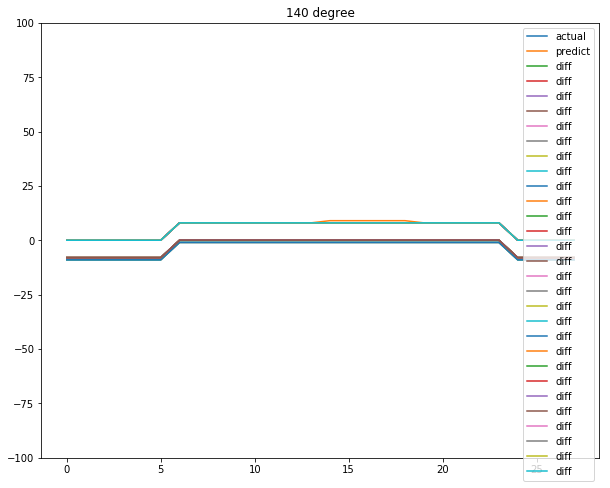

RMSE: 5.530527524014102 




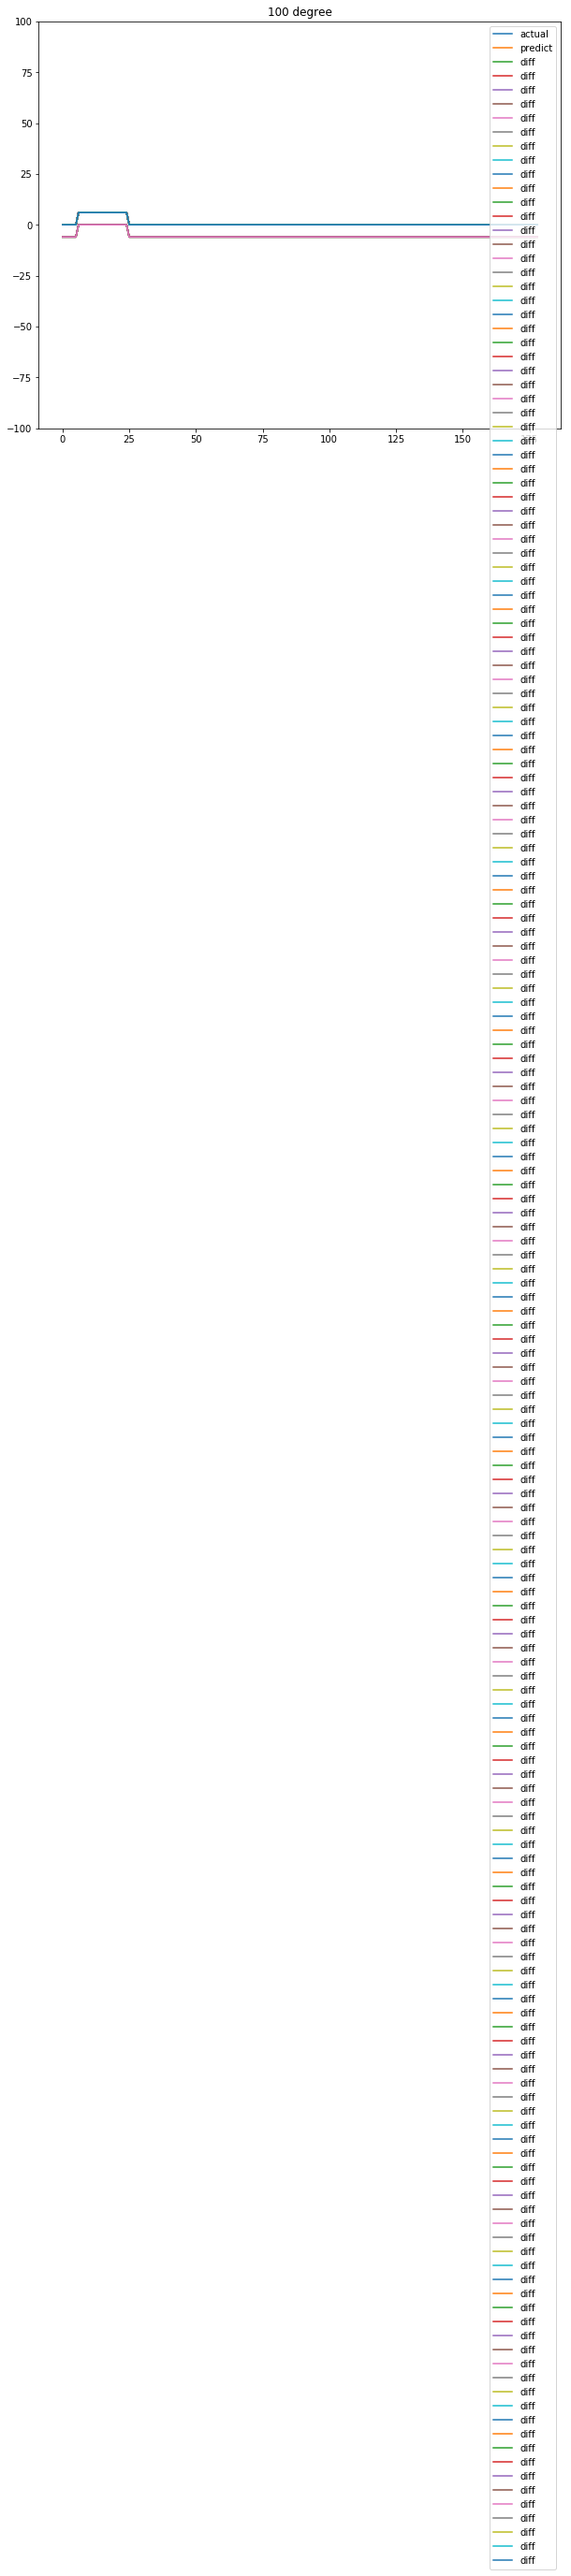

RMSE: 2.6136655226303365 




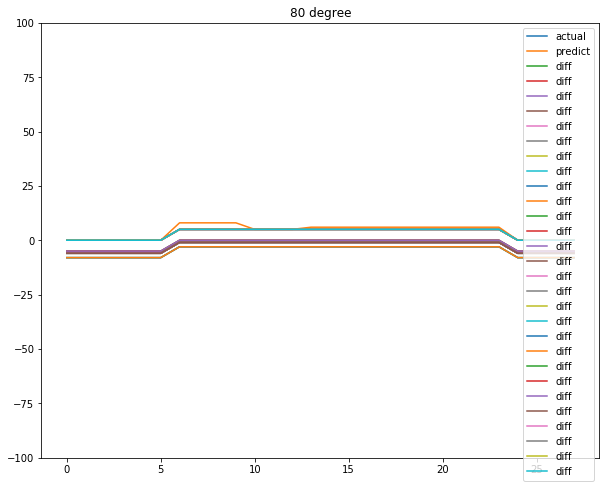

RMSE: 4.011463166313992 




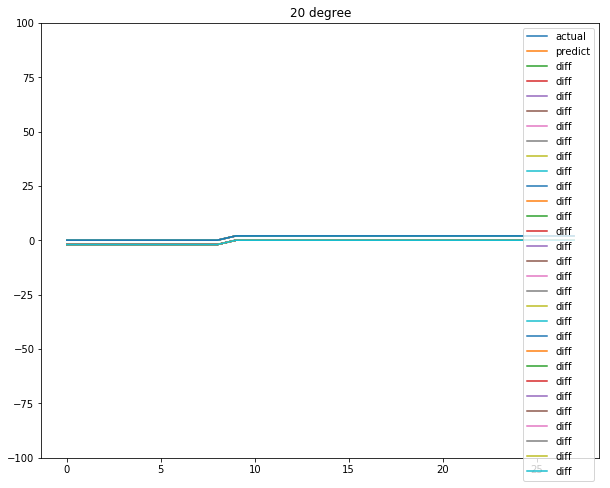

RMSE: 1.3209458577790665 




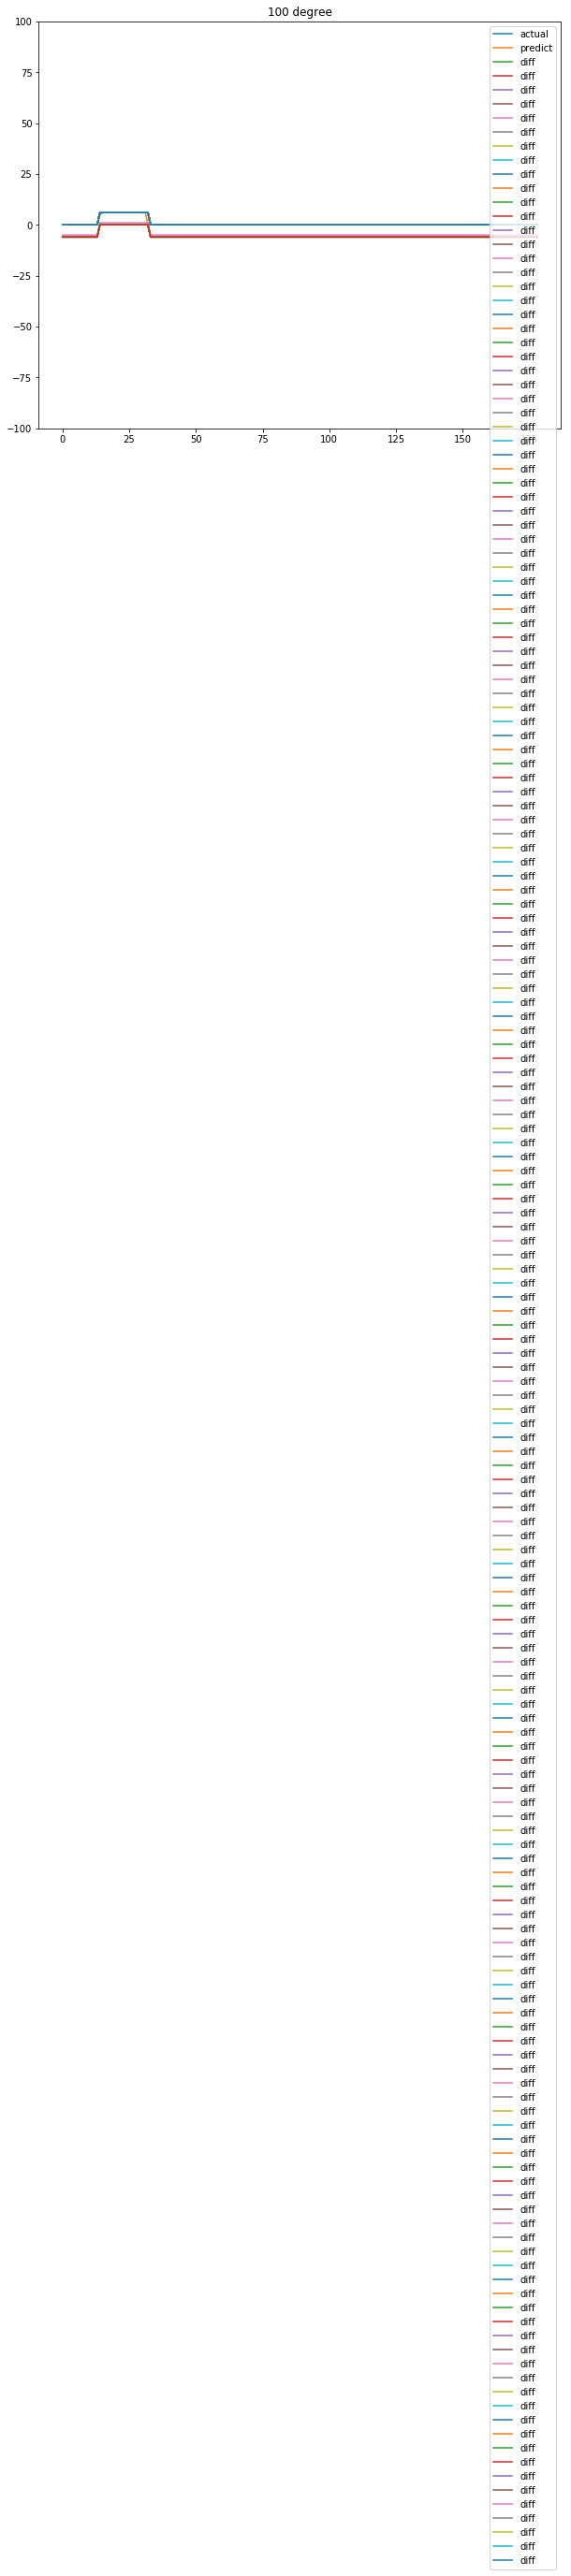

RMSE: 13.690987946924388 




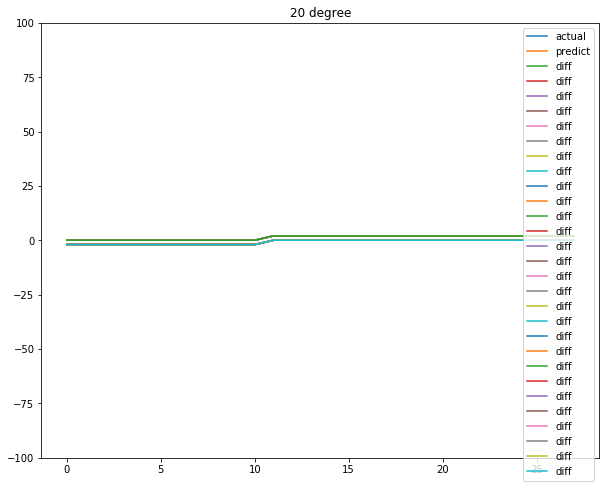

RMSE: 1.381362828986694 




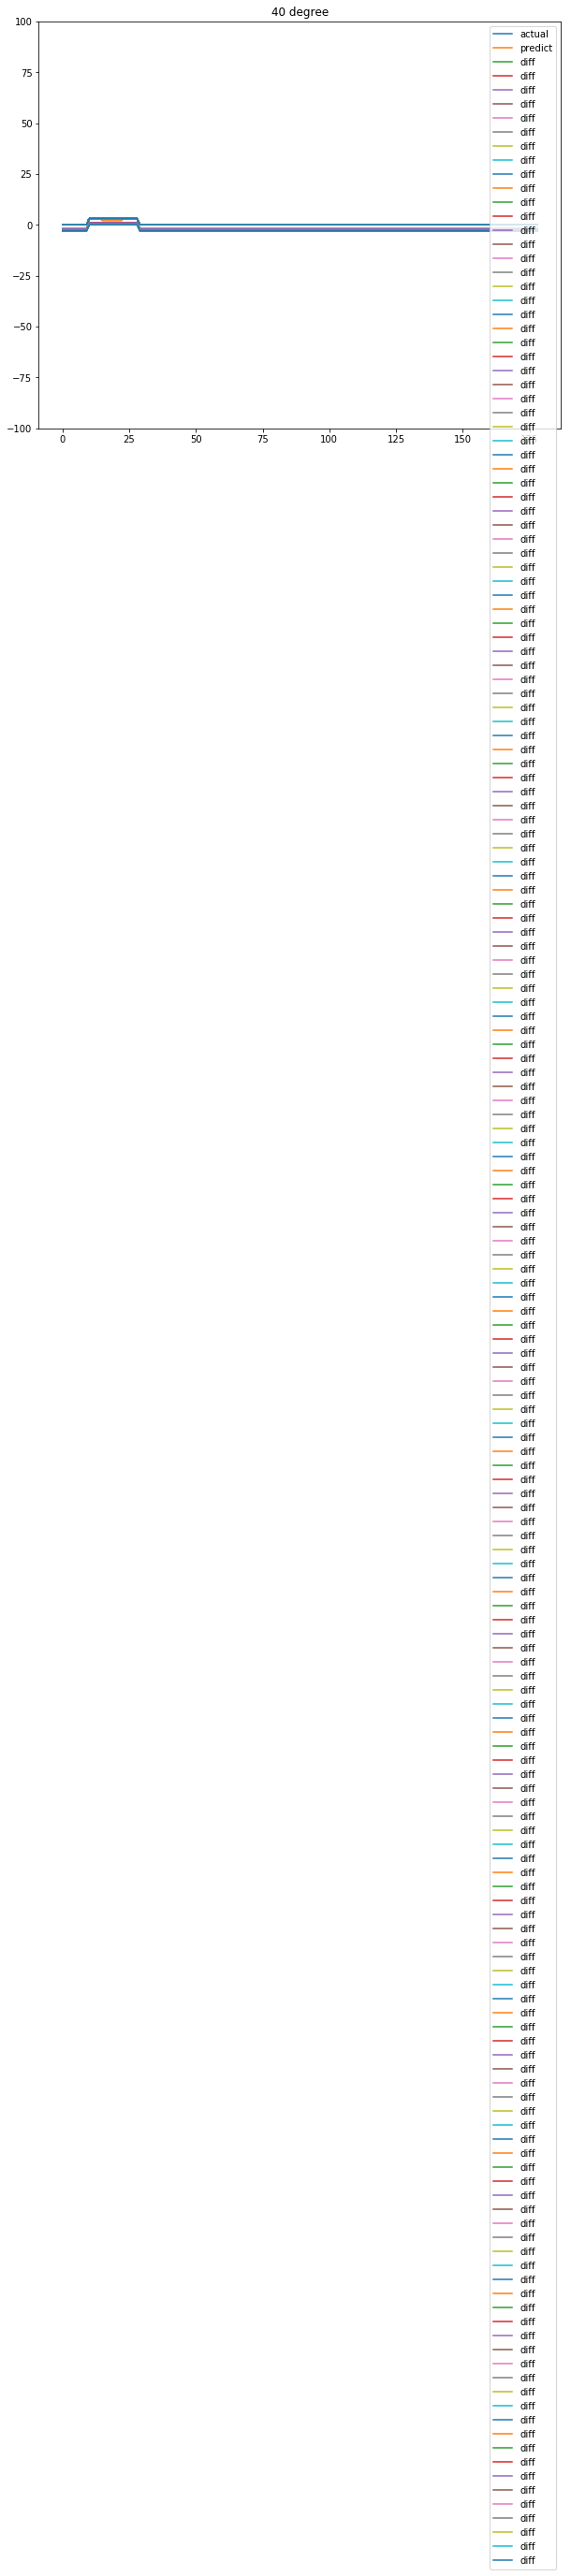

RMSE: 1.229964109231065 




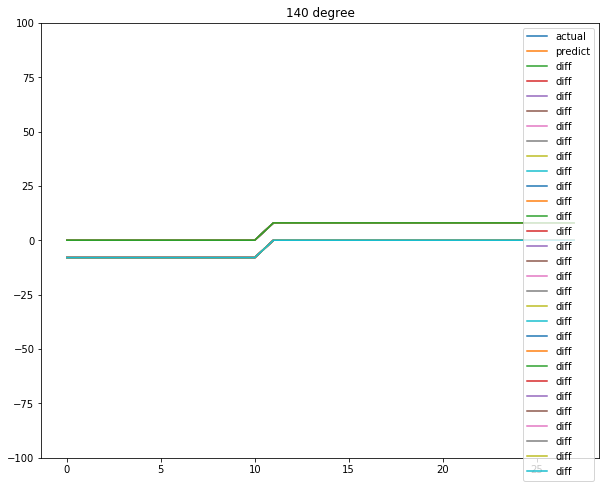

RMSE: 5.525451315946776 




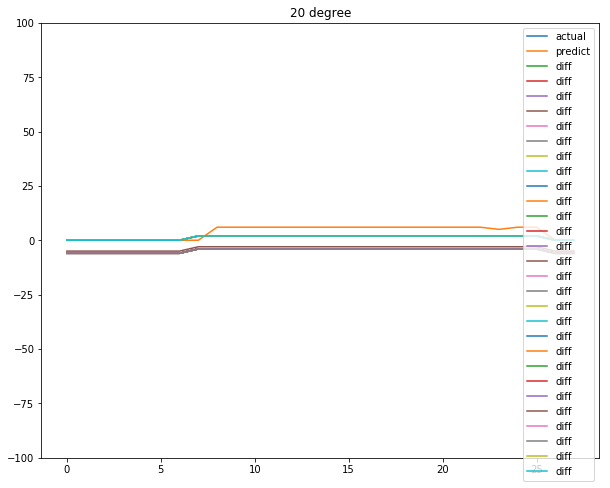

RMSE: 3.8848213259677564 




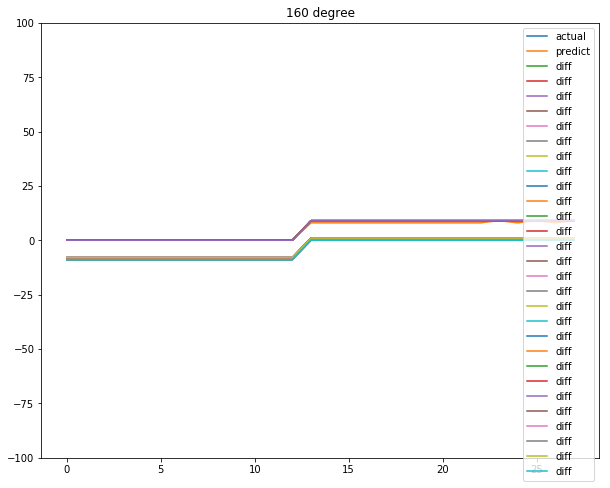

RMSE: 6.0942847096643735 




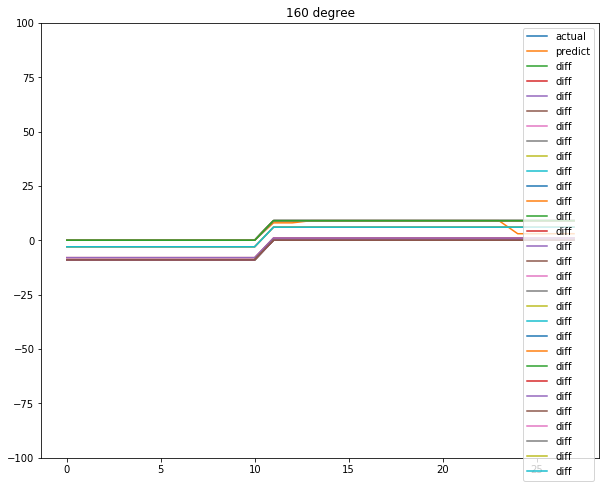

RMSE: 6.106411819237419 




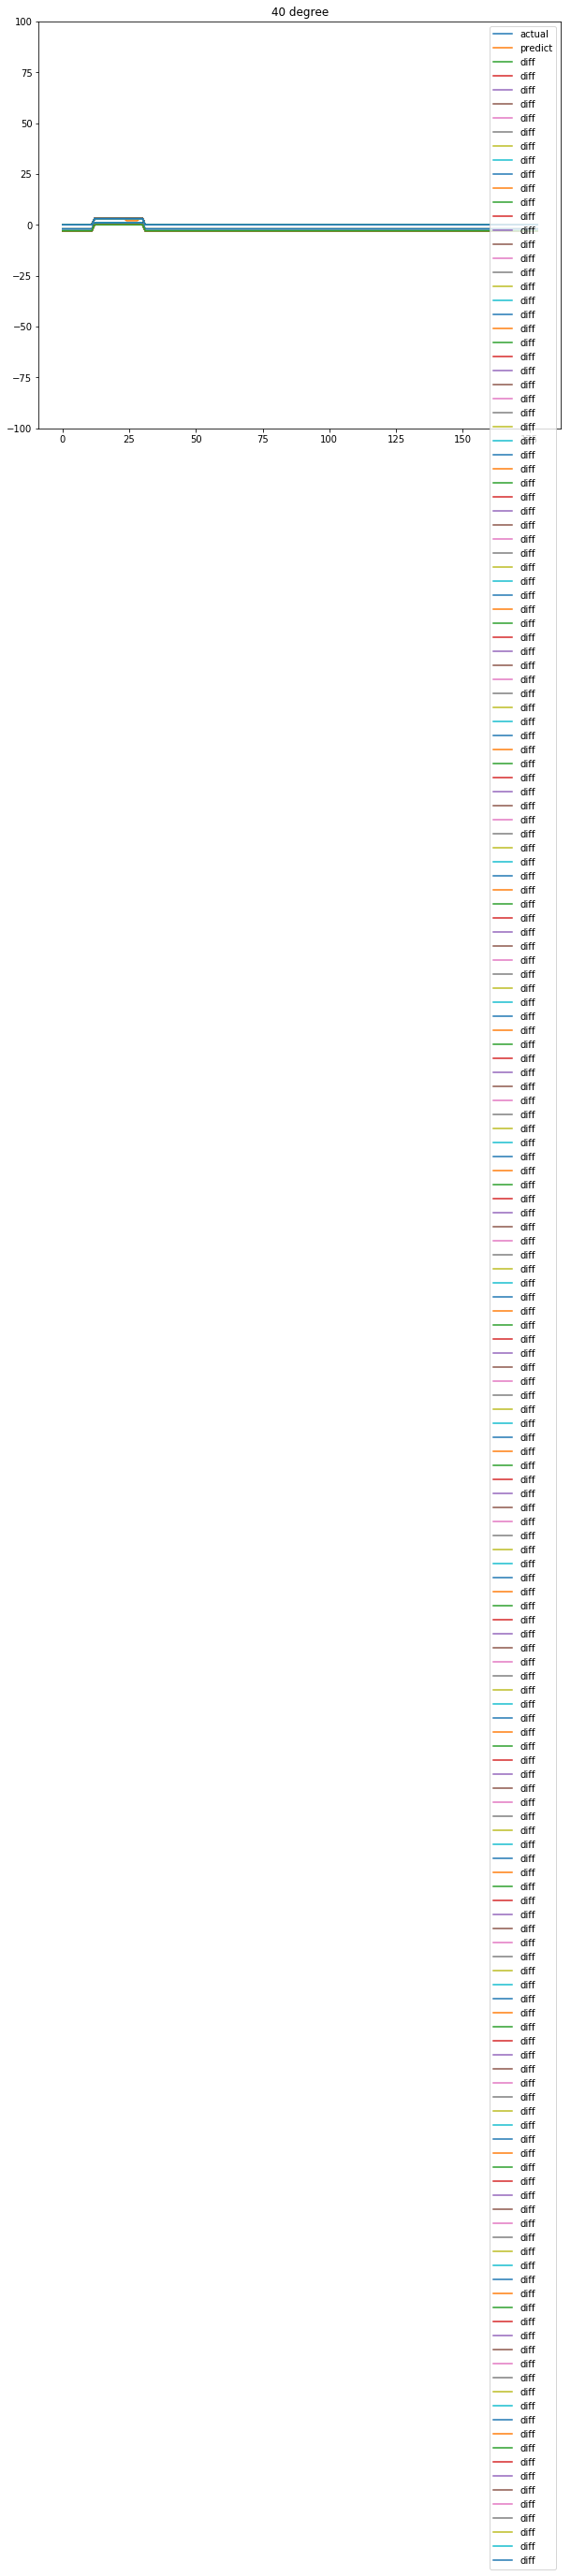

RMSE: 1.2593398145517911 




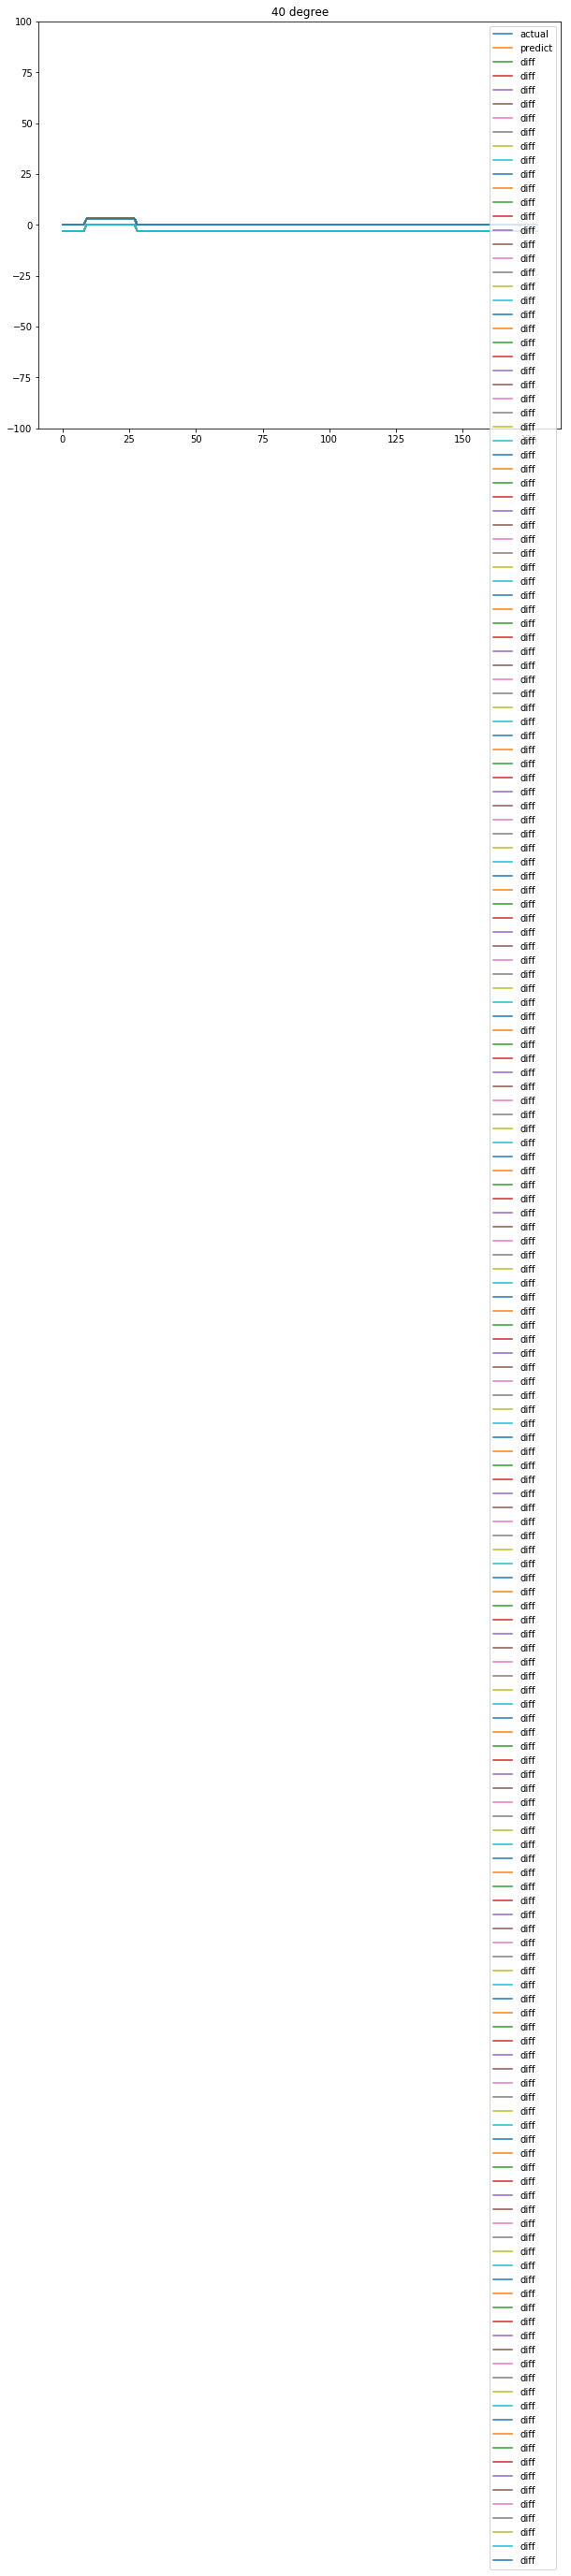

RMSE: 1.3068327613151682 




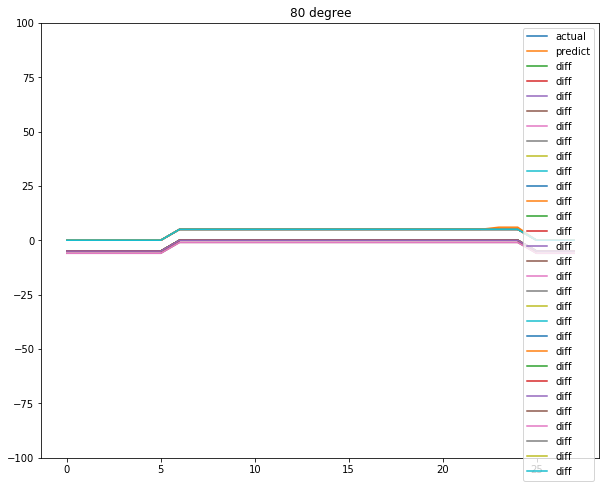

RMSE: 3.3476309015572823 




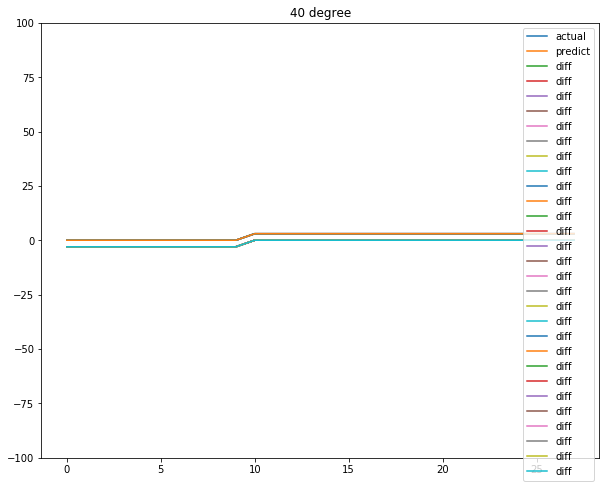

RMSE: 2.032892781536815 




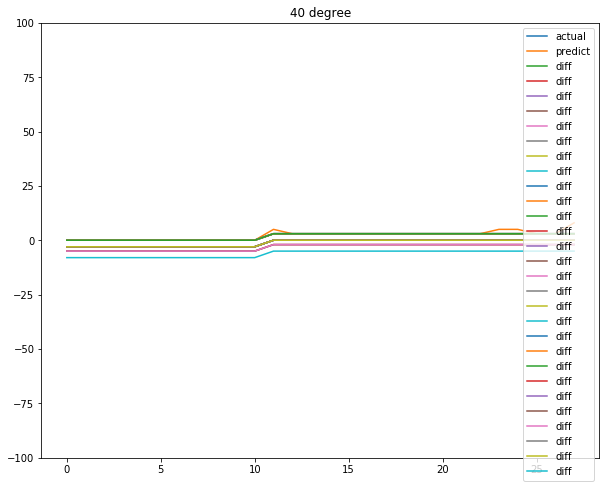

RMSE: 2.557501969995451 




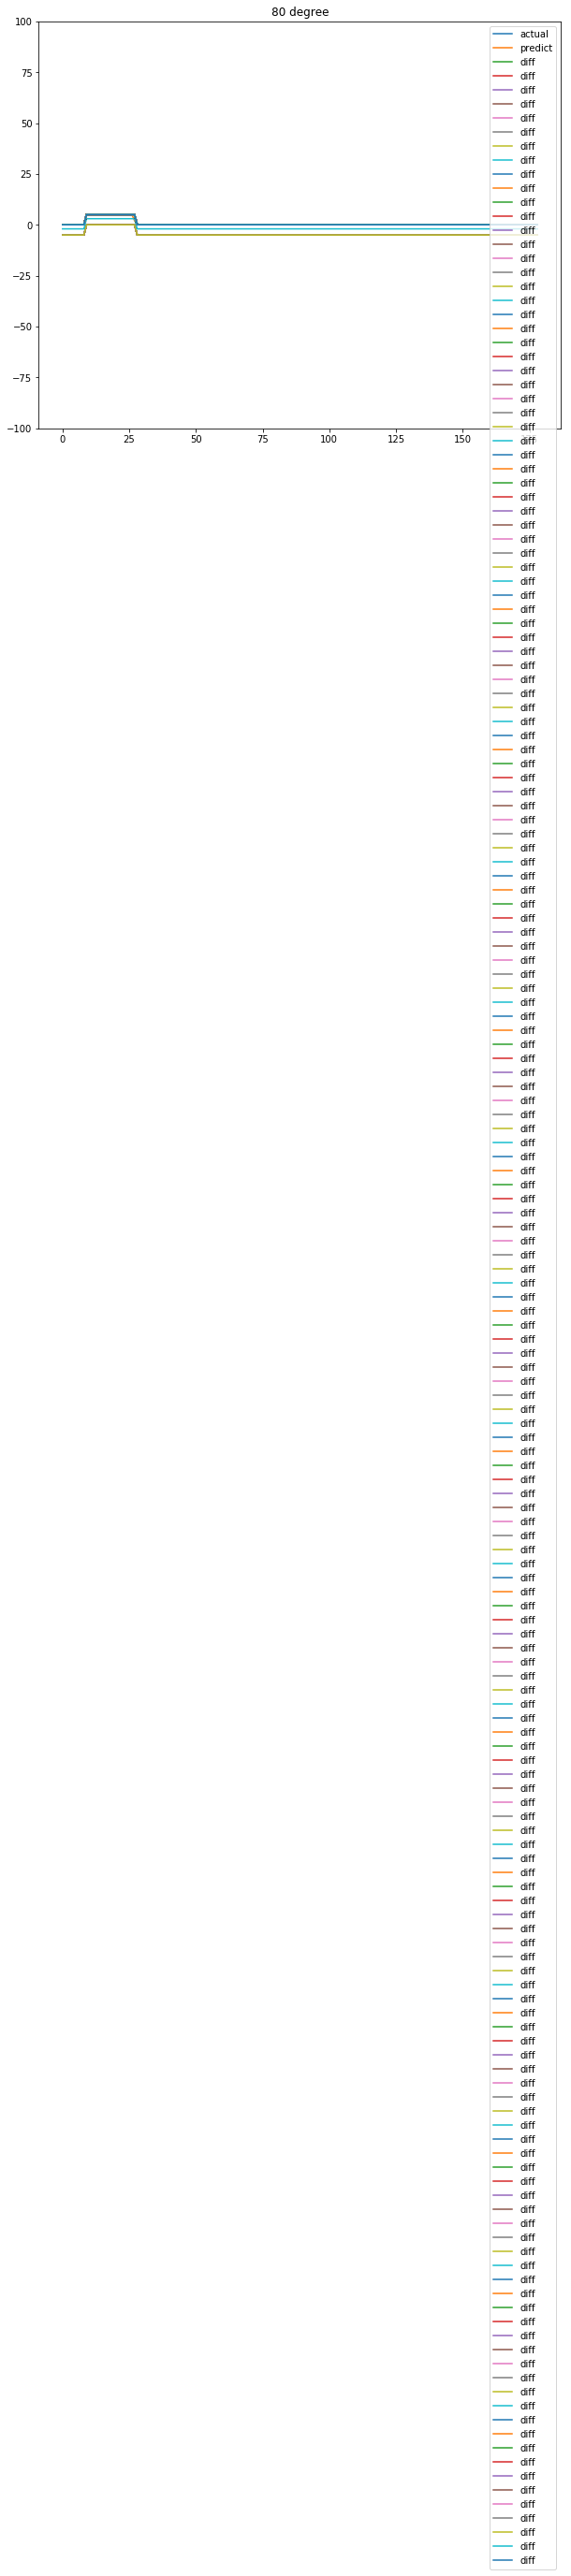

RMSE: 2.1550854092850513 




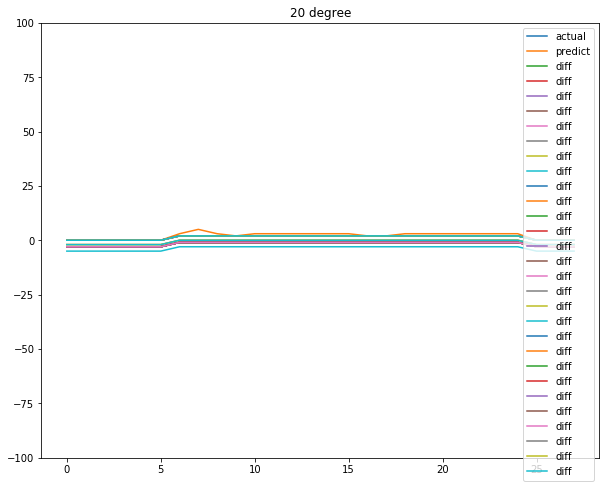

RMSE: 1.8516401995451028 




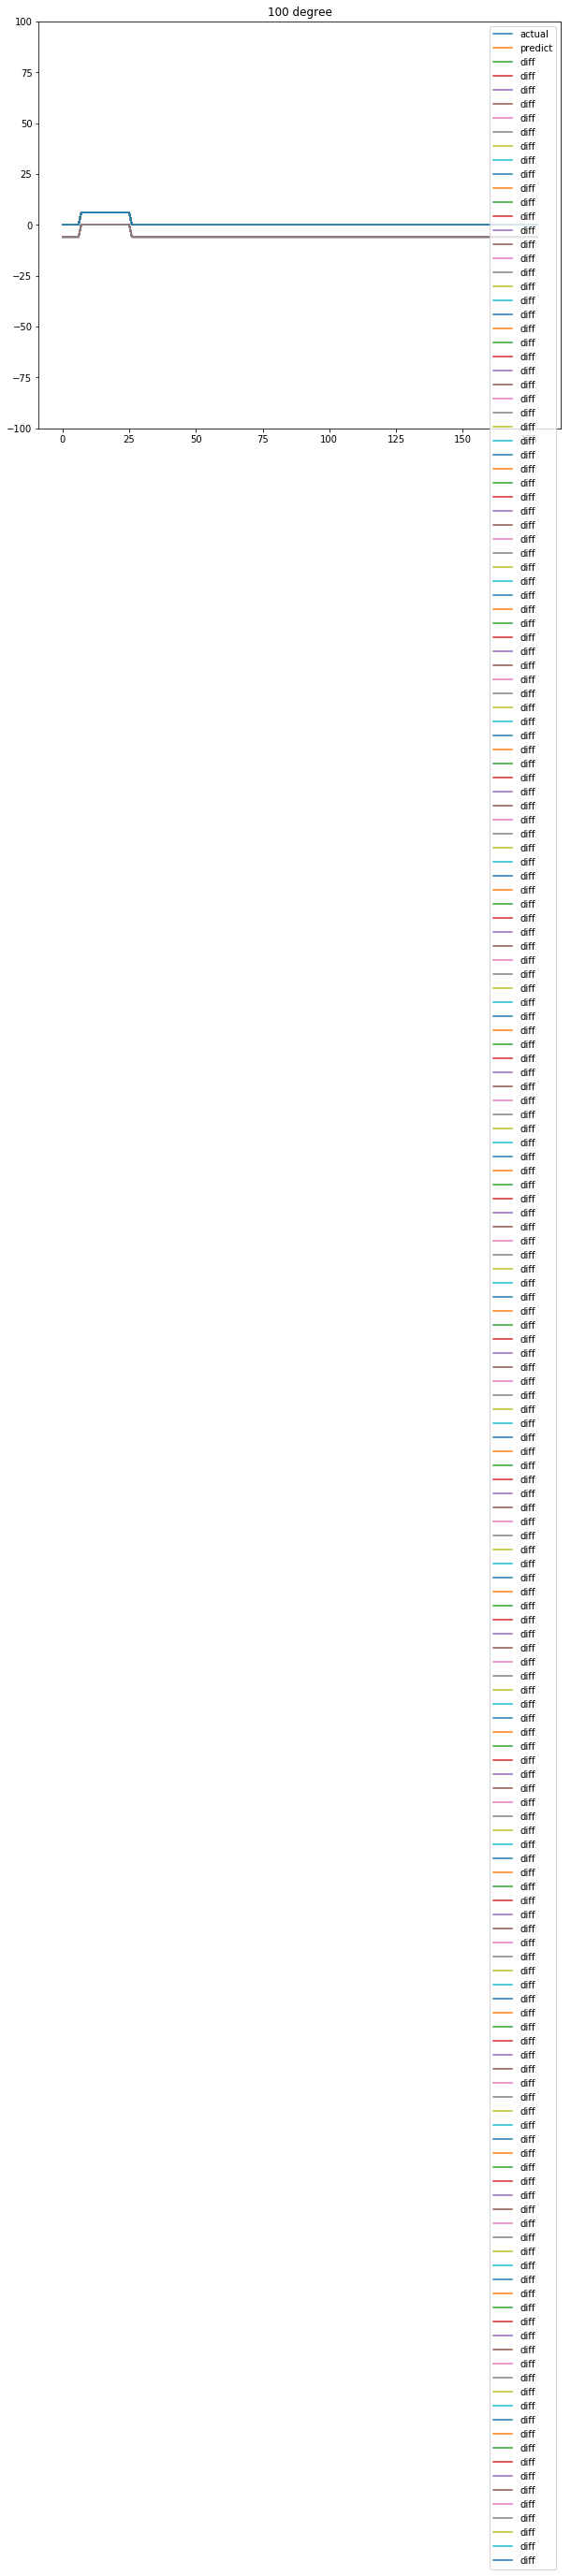

RMSE: 2.6136655226303365 




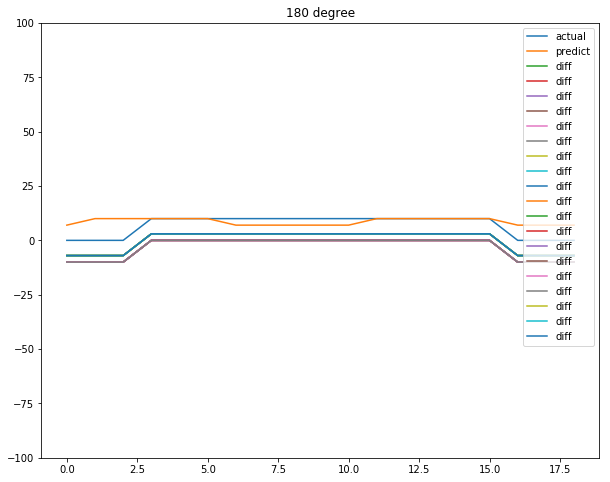

RMSE: 101.165685115435 




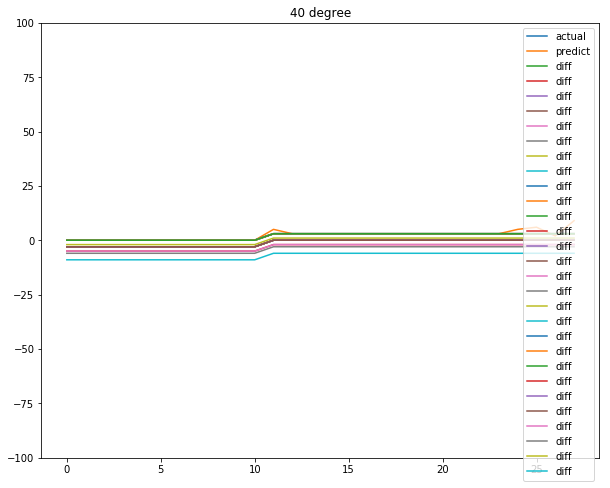

RMSE: 2.689264371002386 




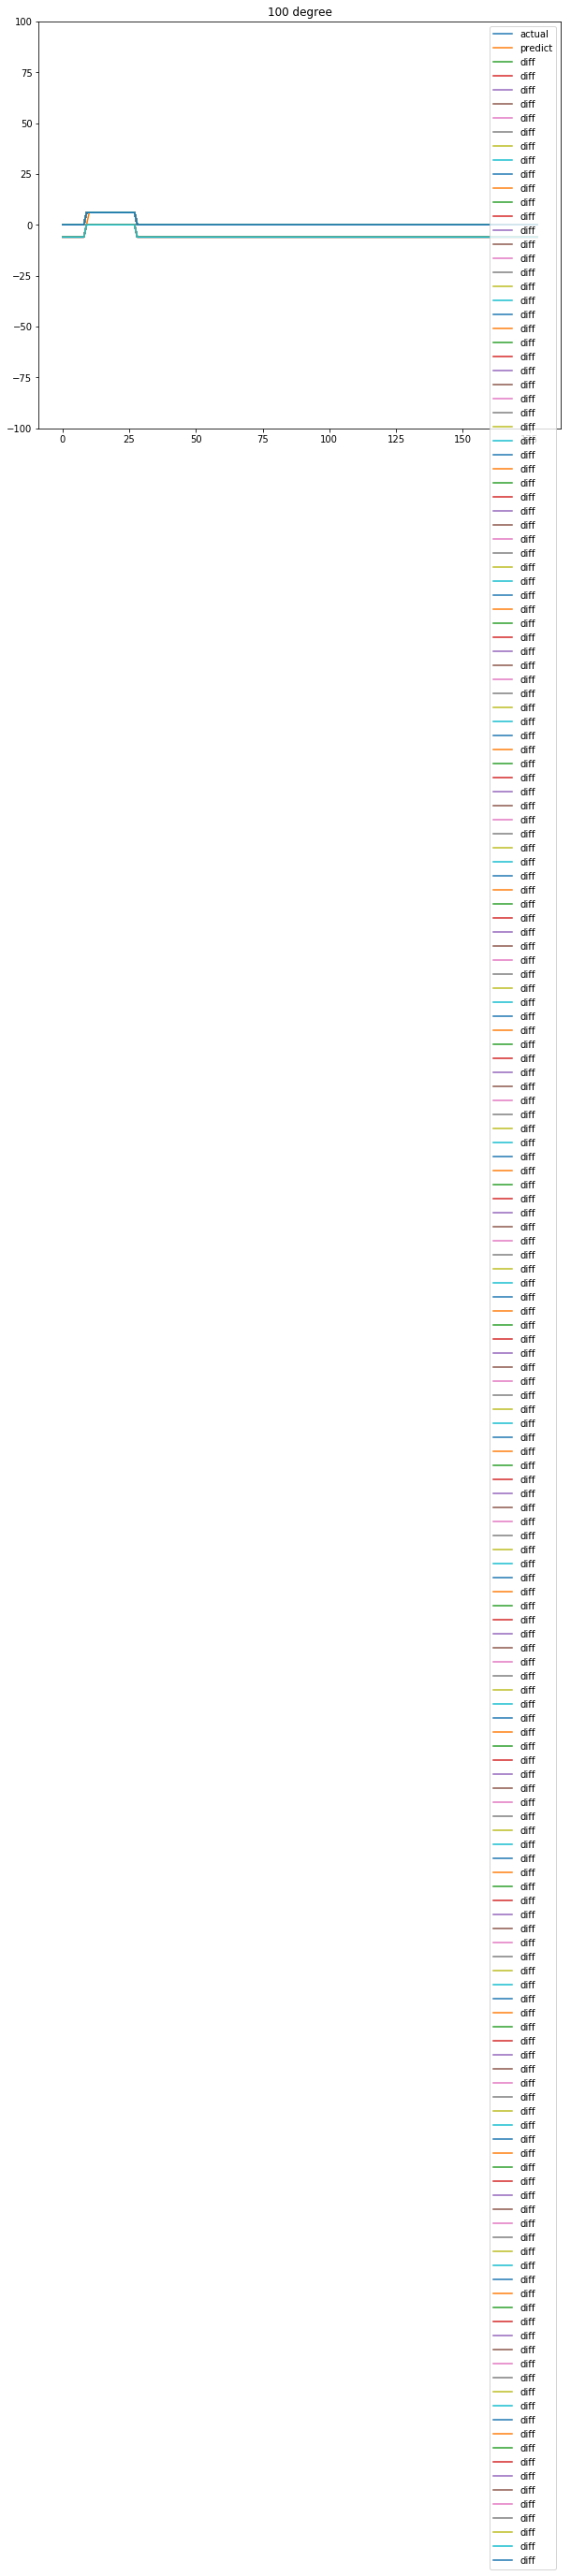

RMSE: 2.583181263946052 




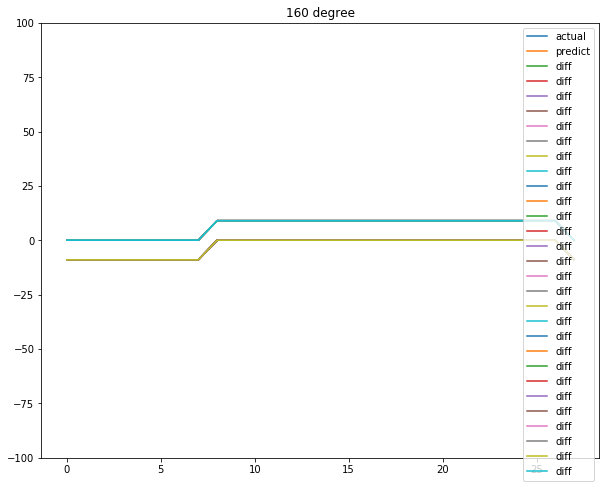

RMSE: 5.944256360005799 




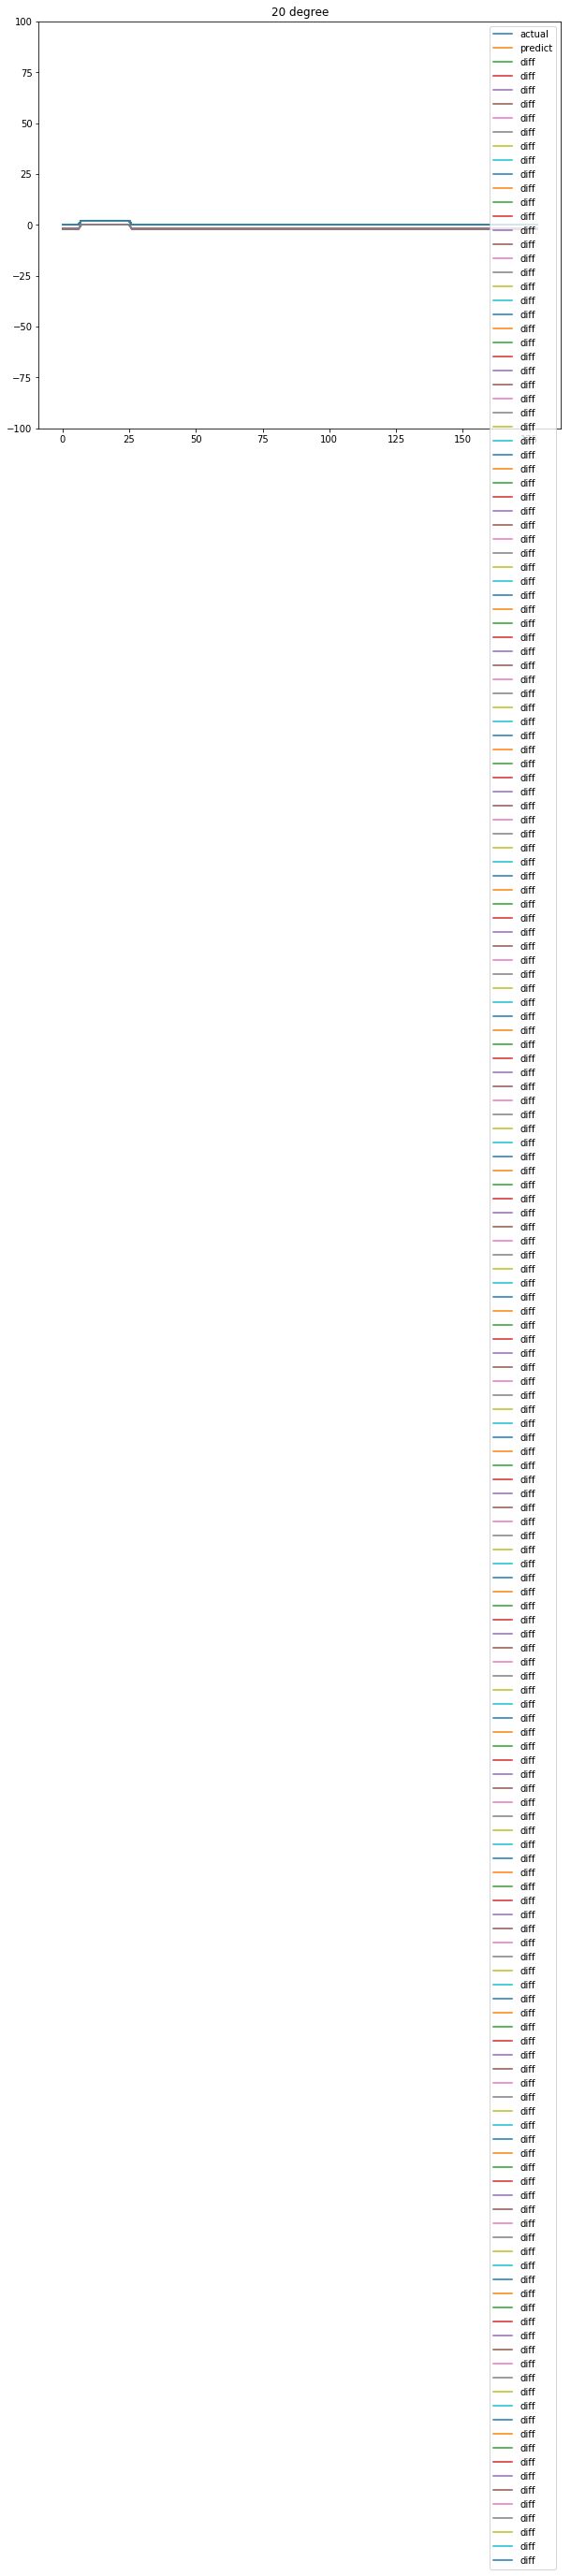

RMSE: 0.8712218408767789 




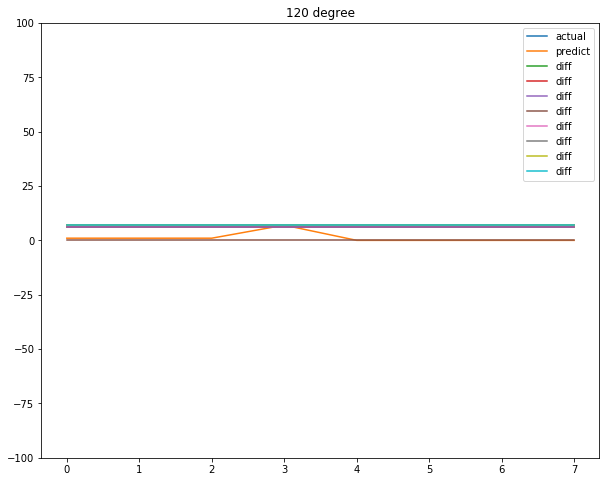

RMSE: 6.164414002968976 




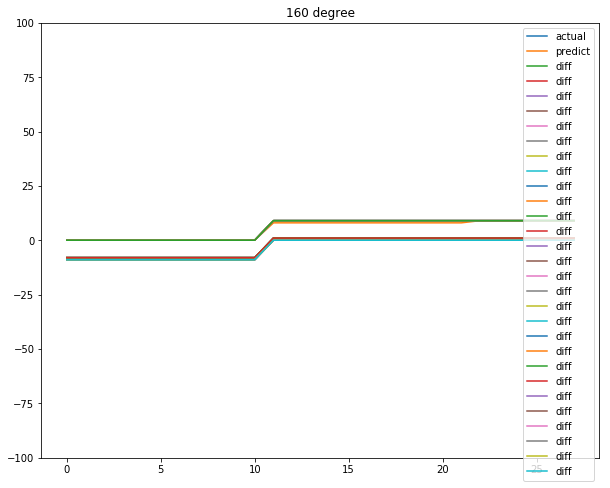

RMSE: 6.0212209759164566 




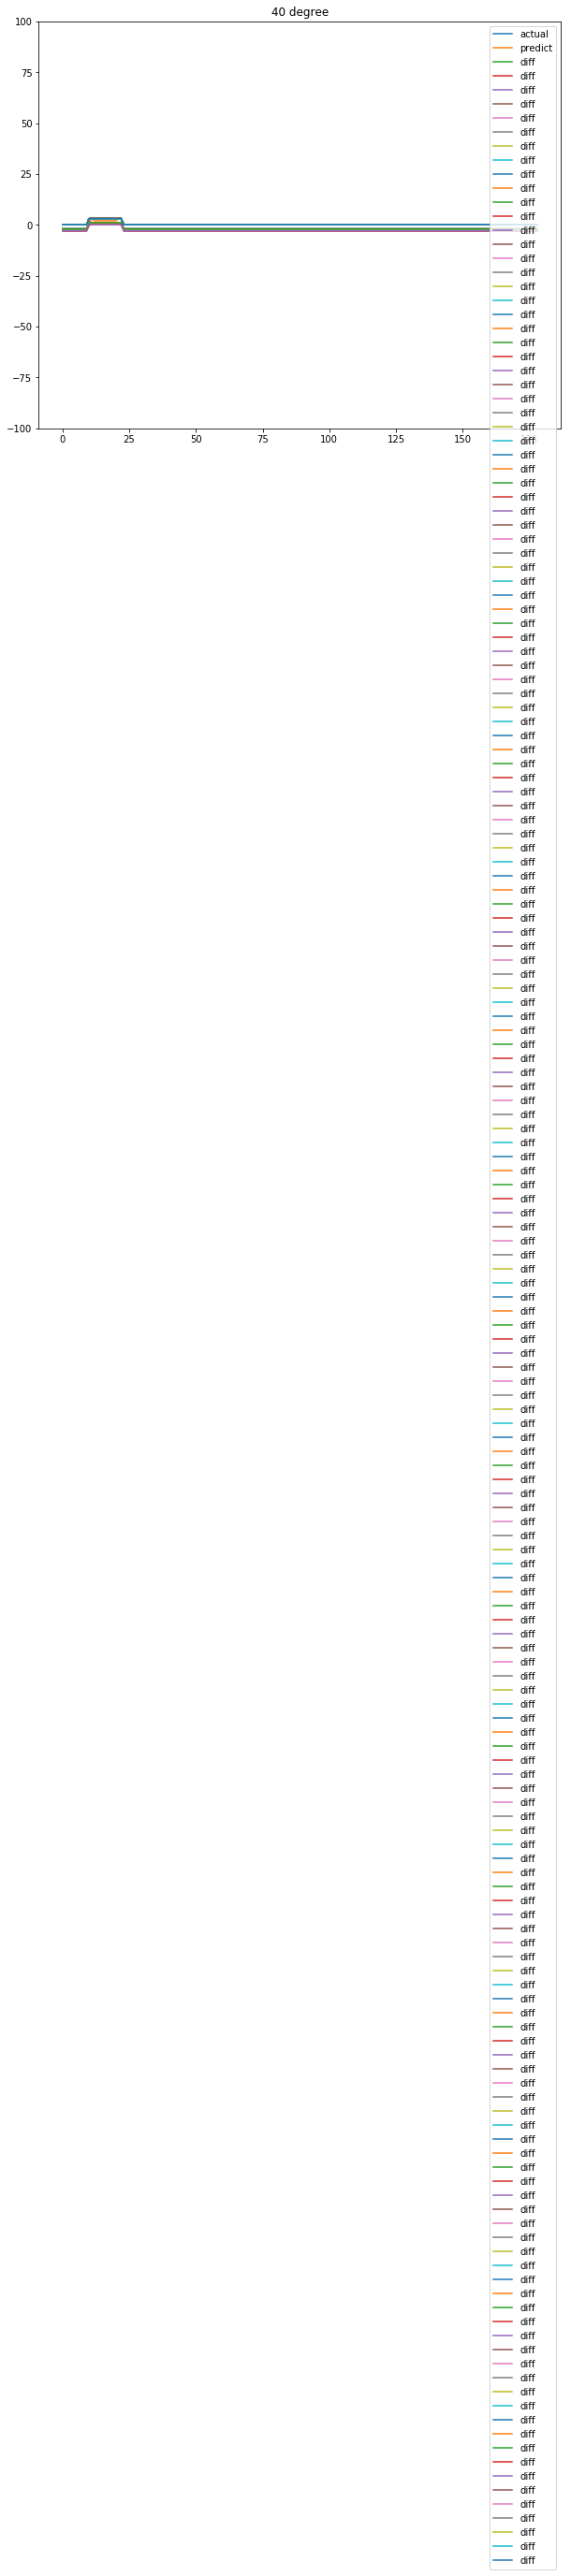

RMSE: 13.48696612883415 




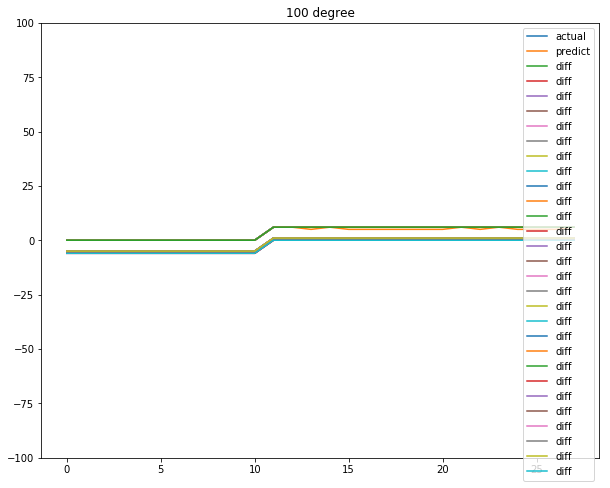

RMSE: 3.9641248358604595 




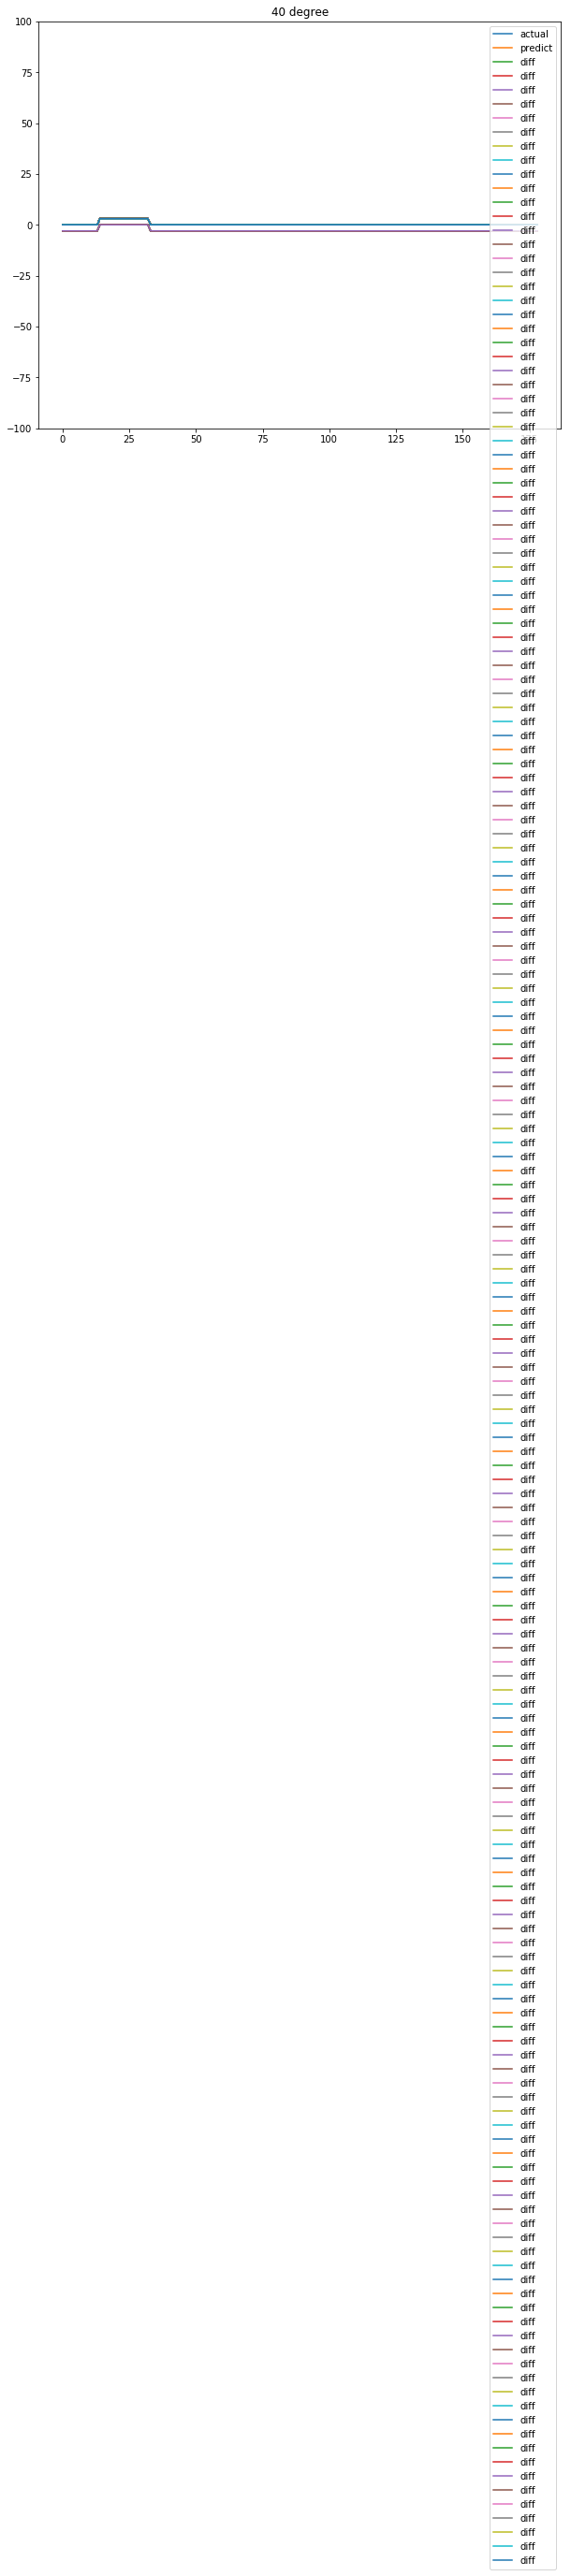

RMSE: 1.3068327613151682 




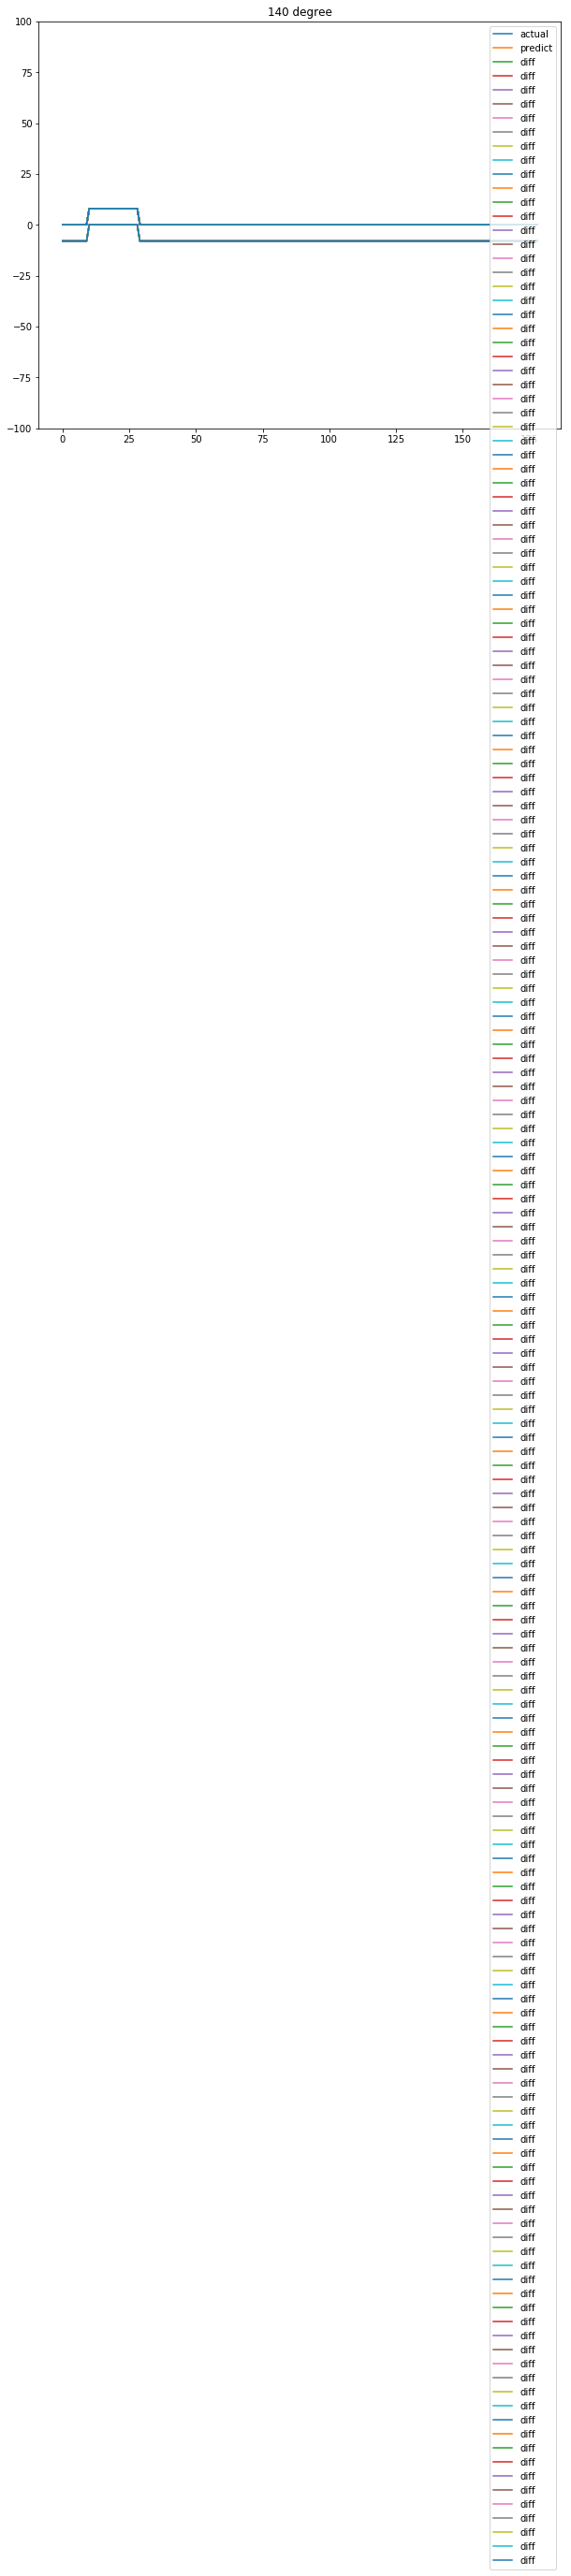

RMSE: 3.4848873635071156 




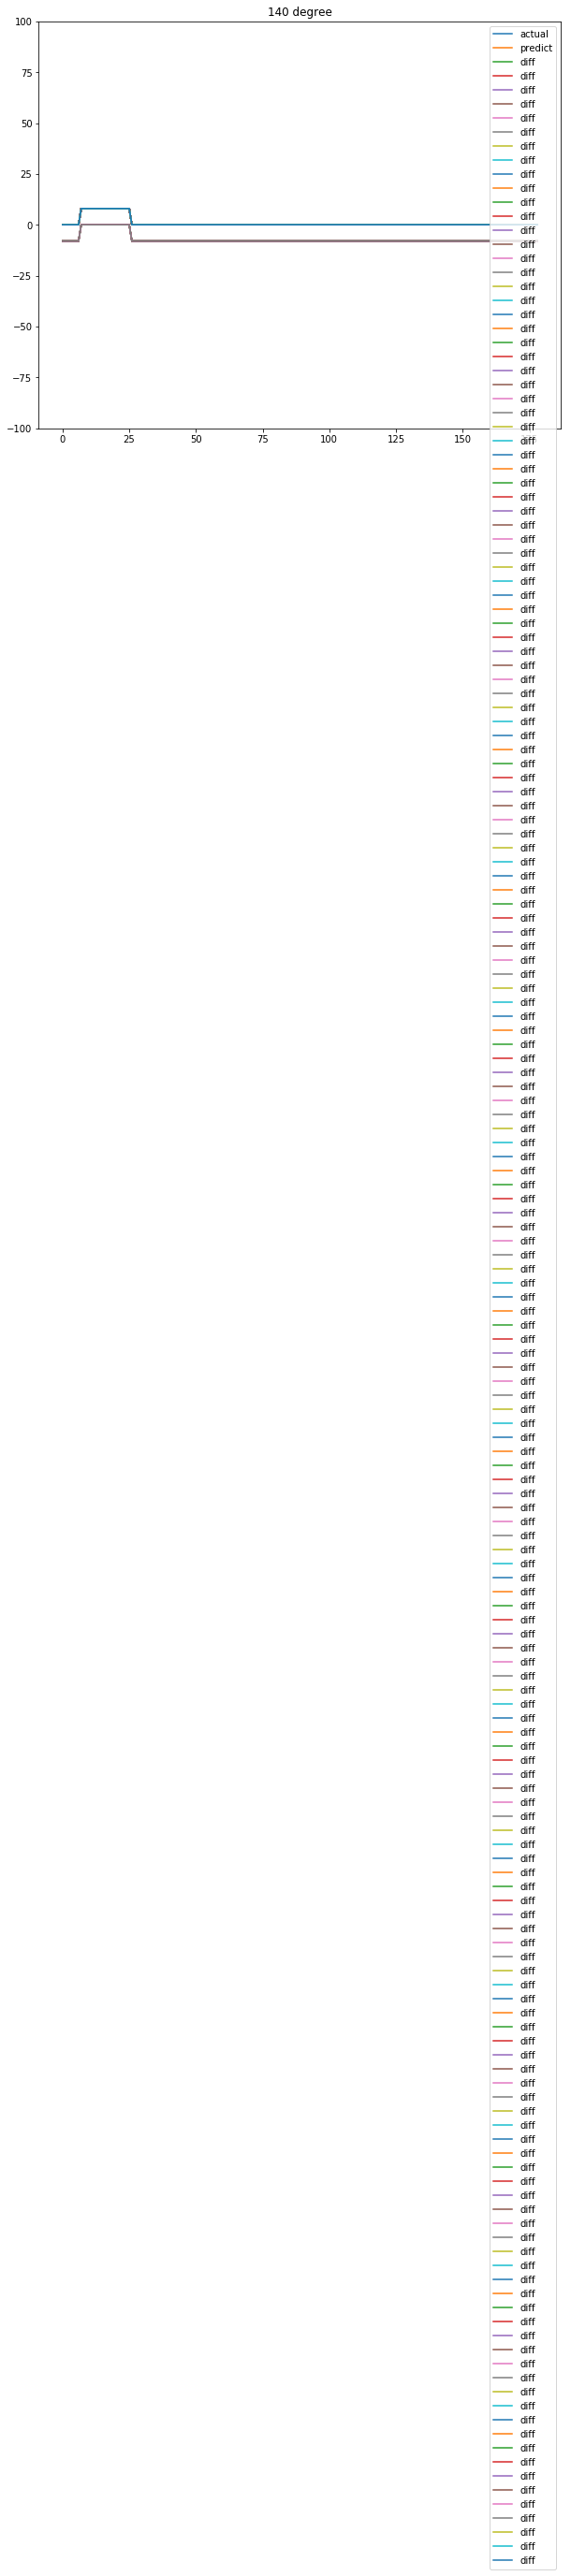

RMSE: 3.4848873635071156 




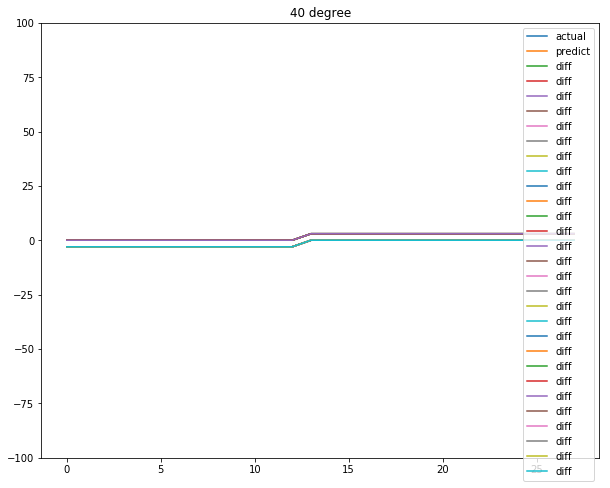

RMSE: 2.1159018919426607 




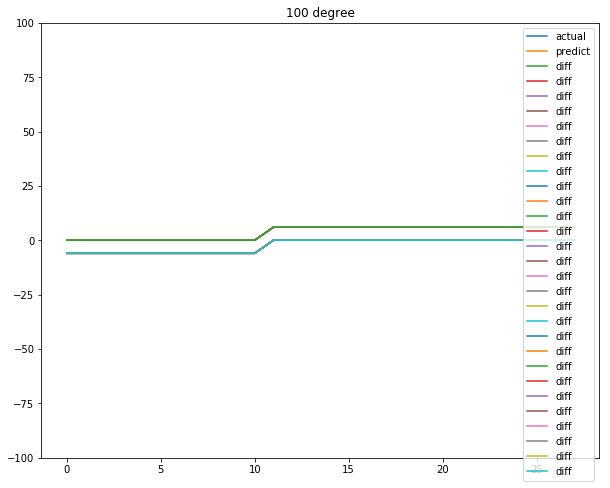

RMSE: 4.144088486960082 




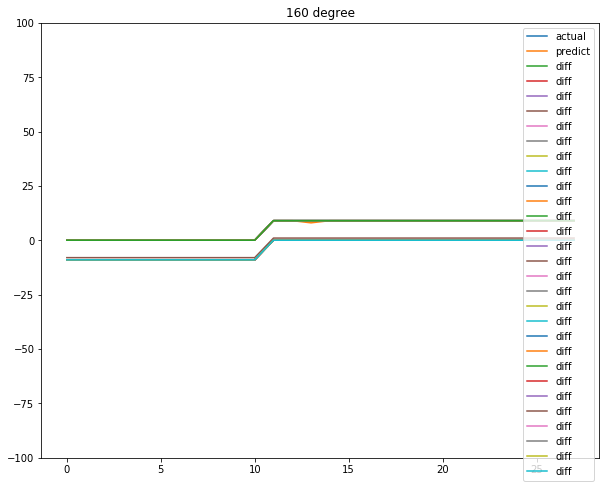

RMSE: 6.19866674275647 




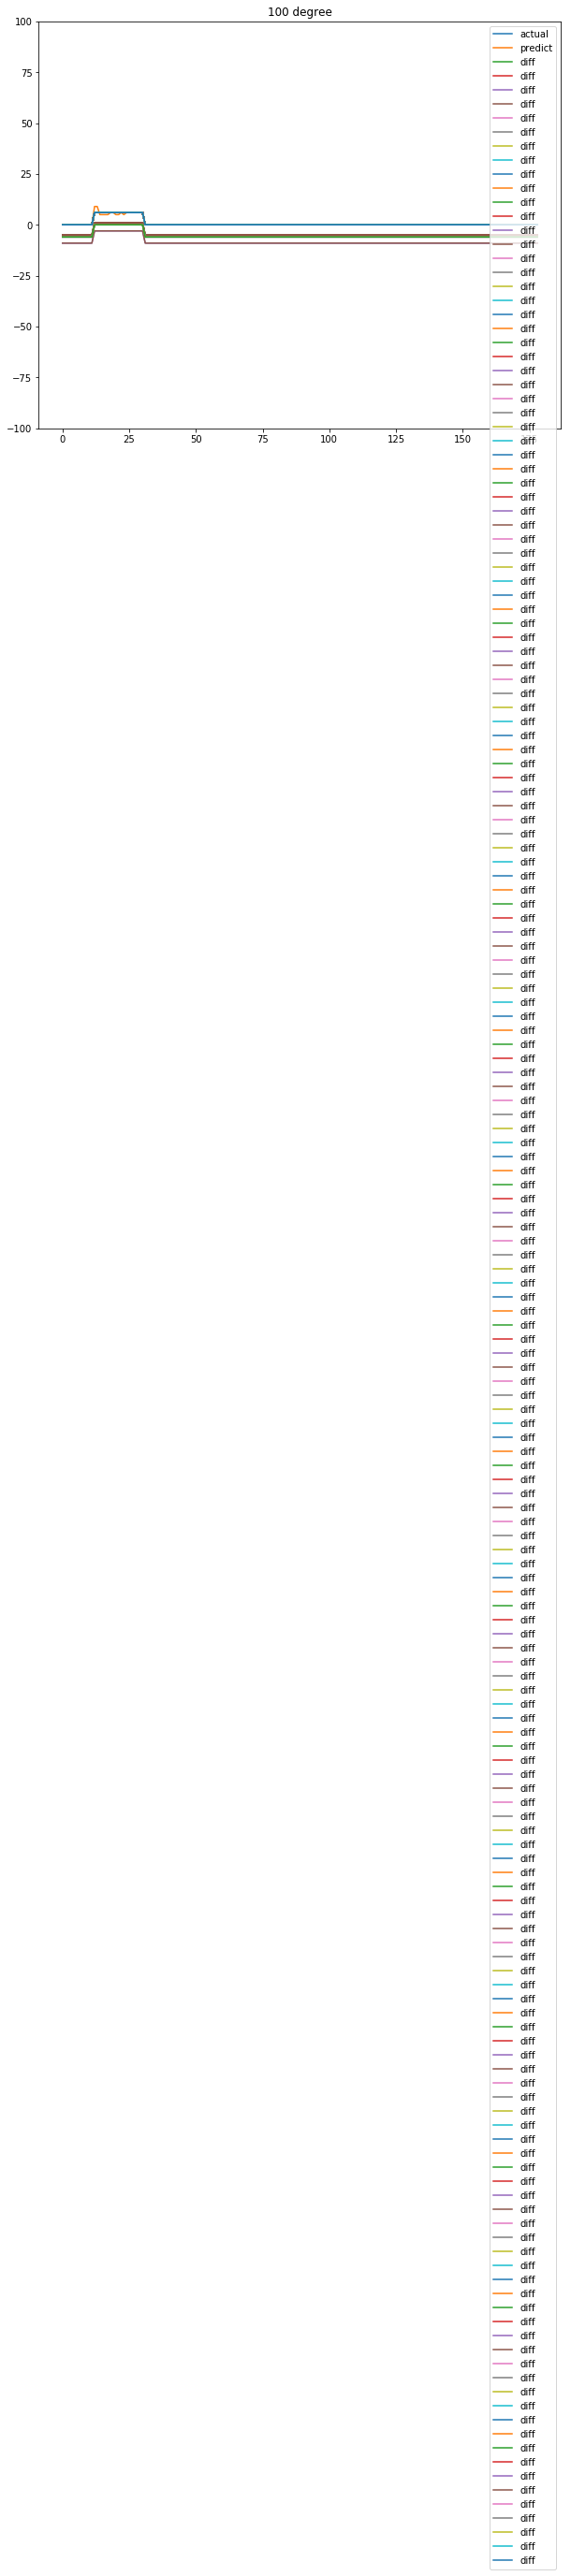

RMSE: 2.6288760041671284 




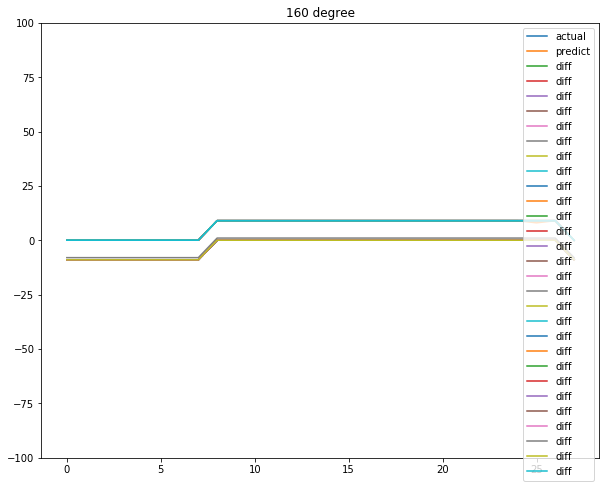

RMSE: 5.929862165862074 




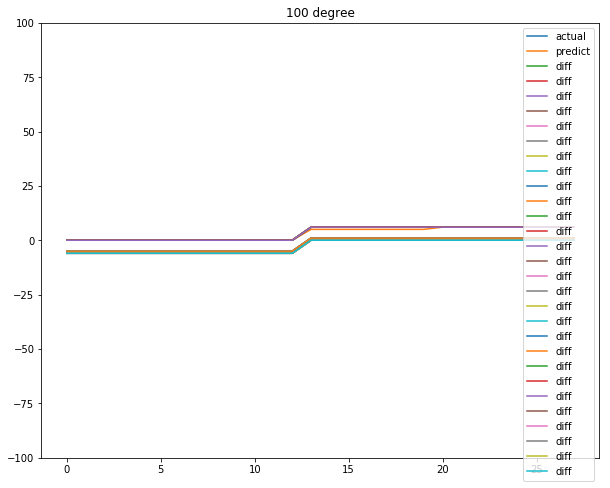

RMSE: 4.094545899419004 




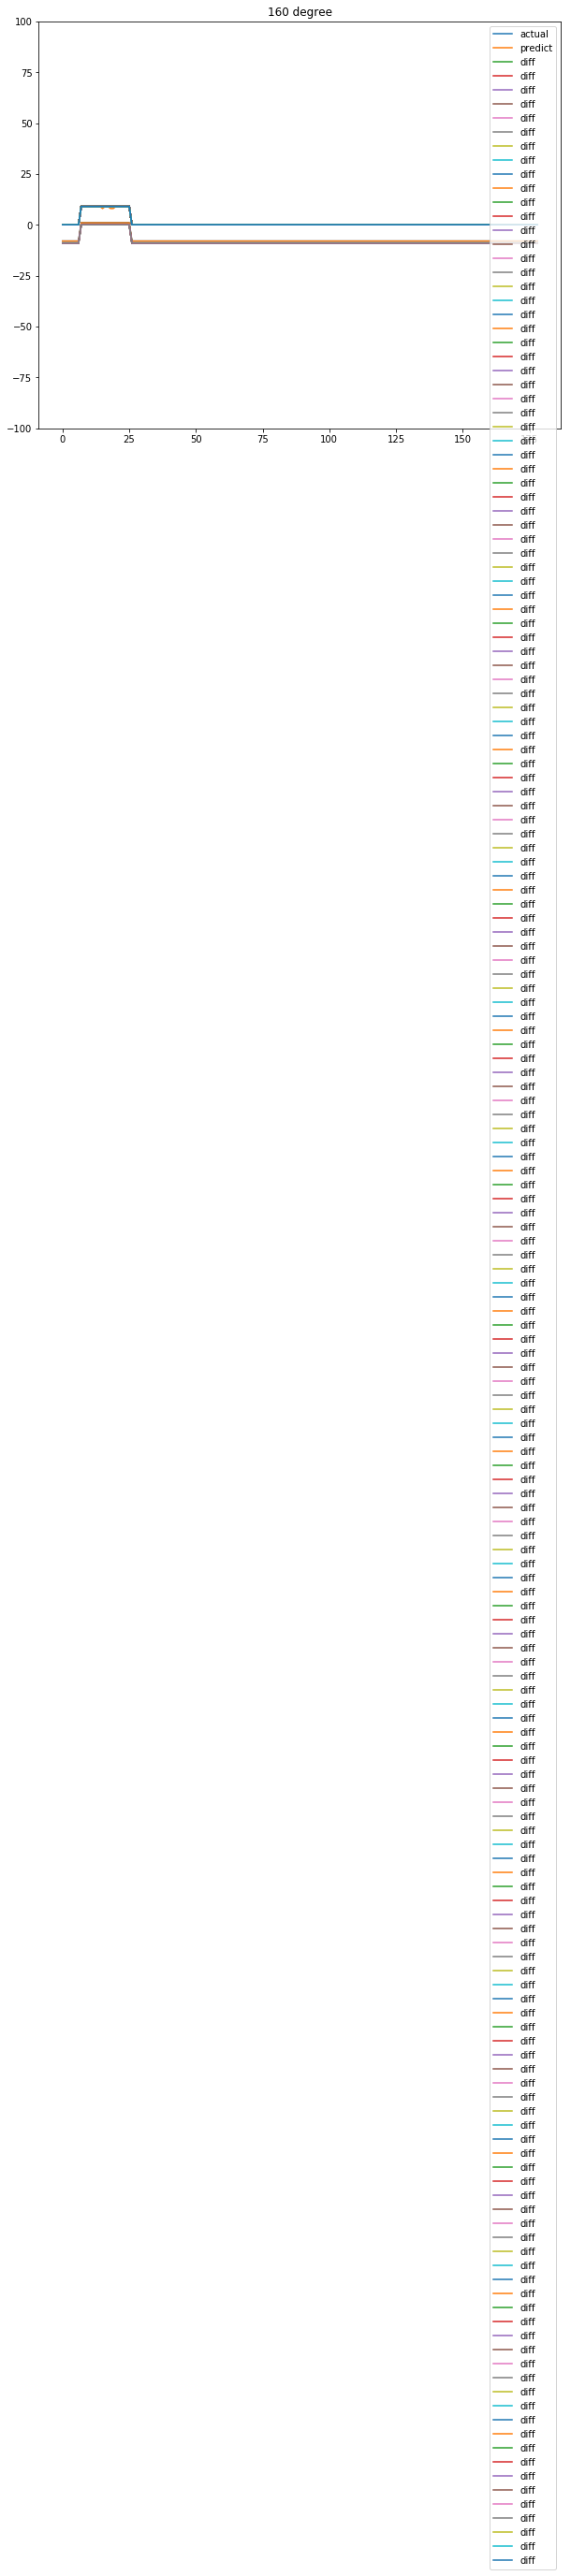

RMSE: 3.888111632372546 




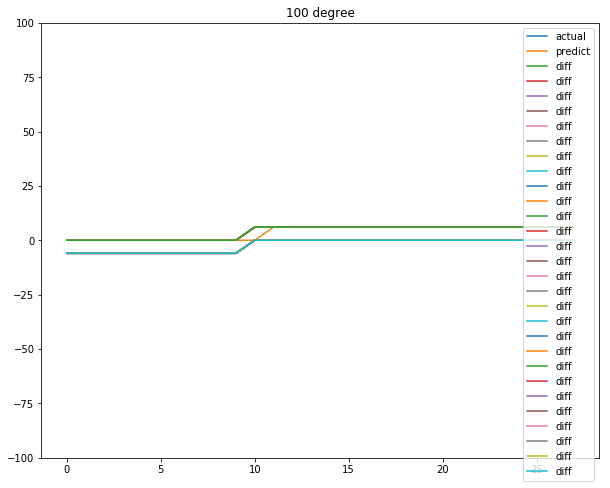

RMSE: 34.256907541191076 




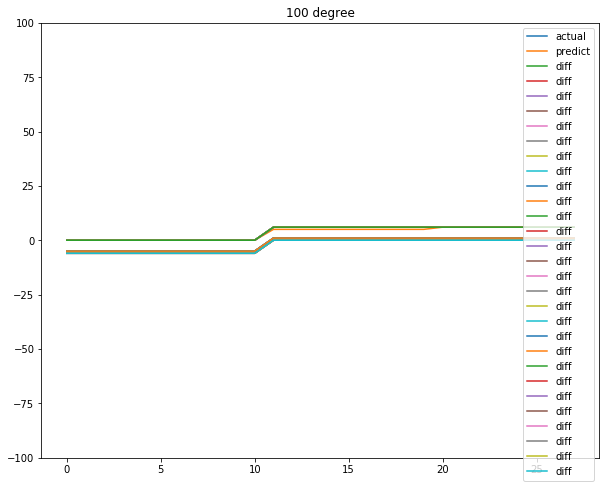

RMSE: 3.9974481656094922 




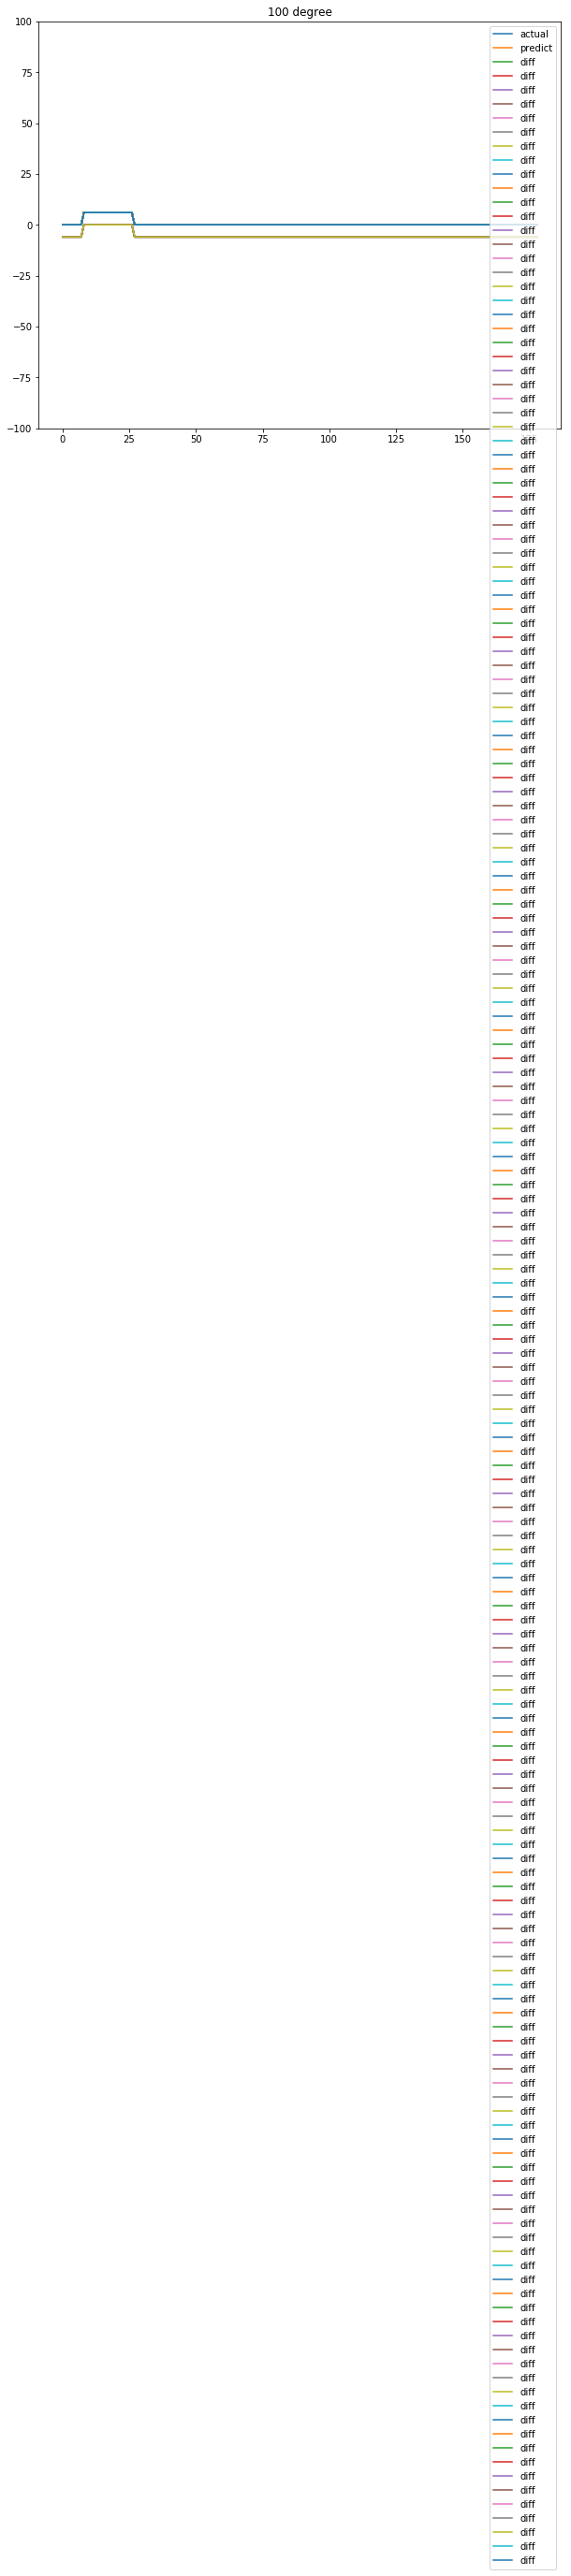

RMSE: 2.6136655226303365 




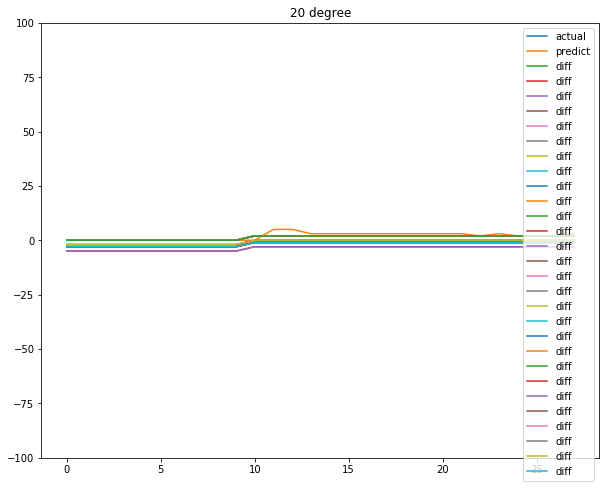

RMSE: 34.070960613737576 




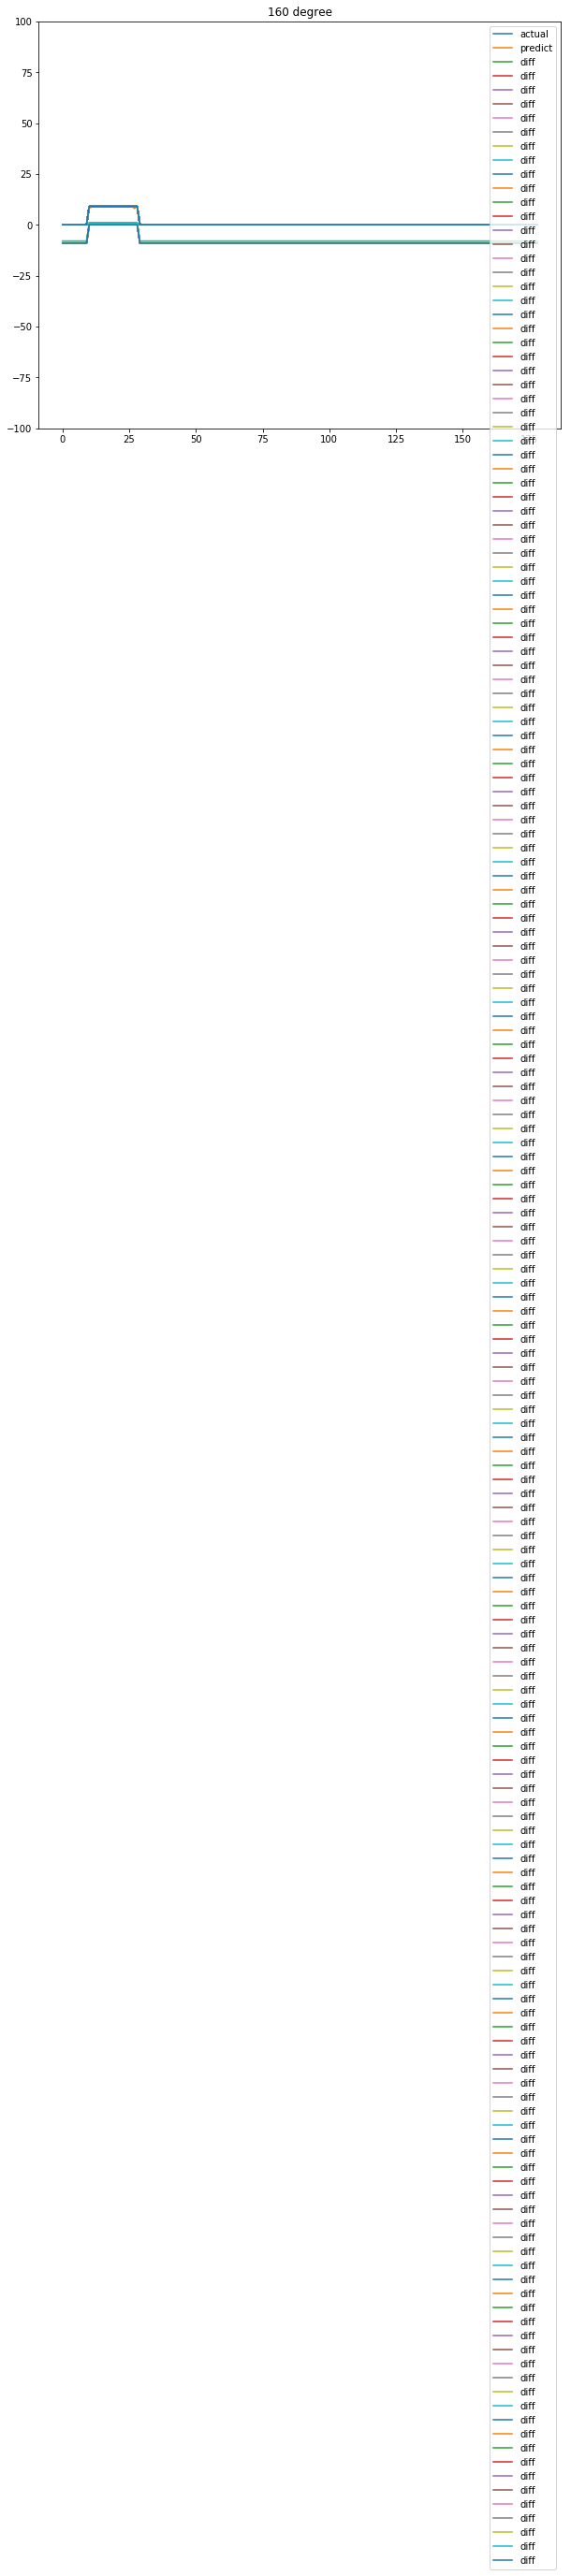

RMSE: 3.898937074212281 




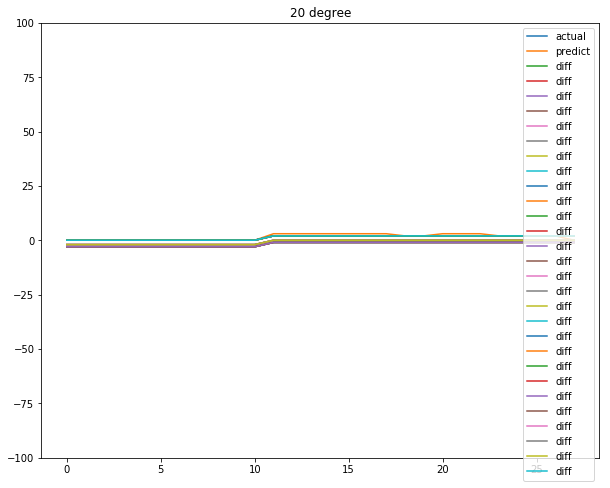

RMSE: 1.6903085094570331 




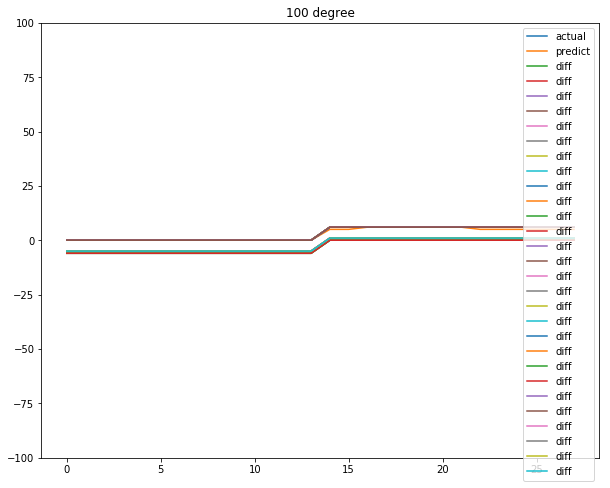

RMSE: 4.0708019567928595 




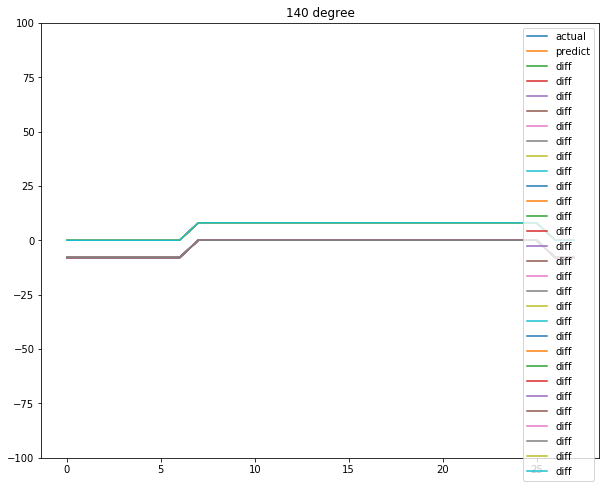

RMSE: 5.283783431116266 




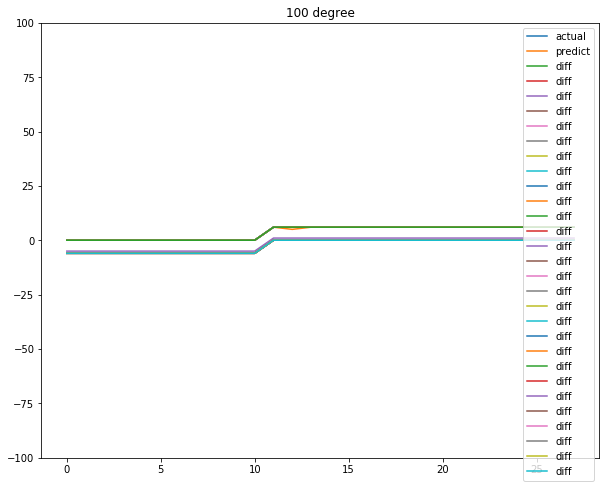

RMSE: 4.128052364799968 




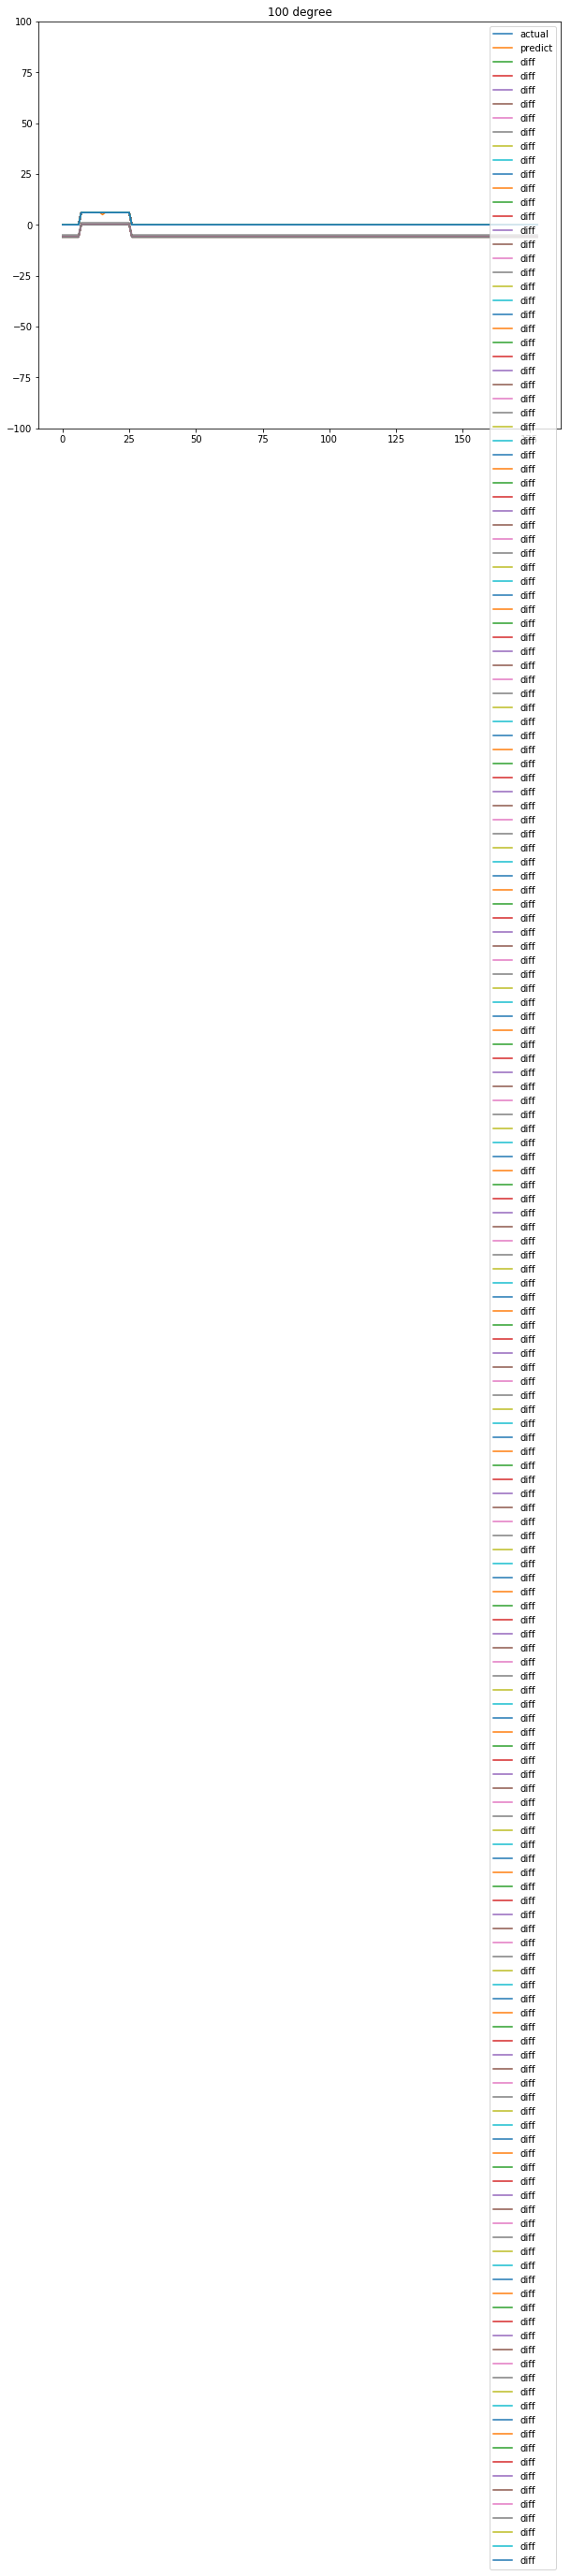

RMSE: 2.60325005195337 




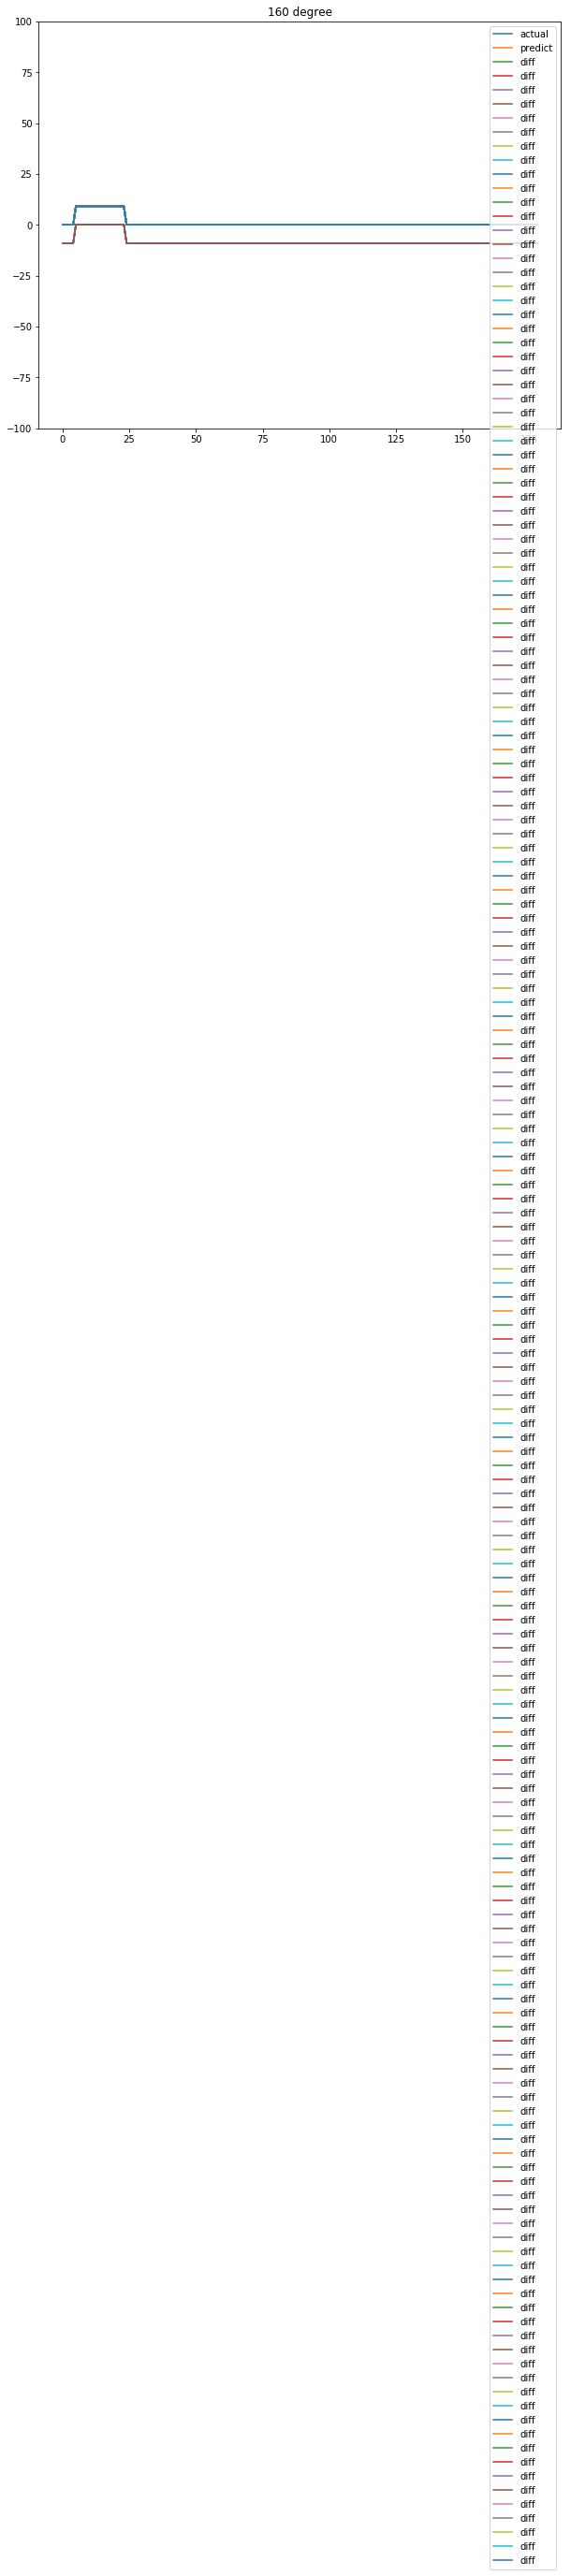

RMSE: 3.920498283945505 




InvalidArgumentError: Reshape cannot infer the missing input size for an empty tensor unless all specified input sizes are non-zero
	 [[{{node model_41/flatten/Reshape}}]]
	 [[{{node vad_out_13/concat}}]]

In [61]:
import matplotlib.pyplot as plt
rmse_list = []
k = 0

for i in val_list:
    if(i < 50):
        vad_pred, pred = predict(model, samples1[i])
    elif((i >= 50) & (i < no_20)):
        vad_pred, pred = predict(model, samples2[i - 50])
    elif((i >= no_20) & (i < no_40)):
        vad_pred, pred = predict(model, samples3[i - no_20])
    elif((i >= no_40) & (i < no_80)):
        vad_pred, pred = predict(model, samples4[i - no_40])
    elif((i >= no_80) & (i < no_100)):
        vad_pred, pred = predict(model, samples5[i - no_80])
    elif((i >= no_100) & (i < no_140)):
        vad_pred, pred = predict(model, samples6[i - no_100])
    elif((i >= no_140) & (i < no_160)):
        vad_pred, pred = predict(model, samples7[i - no_140])
    error = label_instances[i].reshape(-1, 1) - pred
    plt.figure(figsize=(10, 8))
    plt.title('%d degree' %(edge_list[k]))
    plt.plot(range(0, len(label_instances[i])), label_instances[i], label='actual')
    plt.plot(range(0, len(pred)), pred, label='predict')
    #plt.plot(range(0, len(error)), error, label='diff')
    plt.ylim(-100, 100)
    plt.legend()
    plt.show()
        
    for j in range(0, len(error)):
        if((vad_label_instances[i][j] == 0) & (vad_pred[j] != 0) | ((vad_label_instances[i][j] != 0) & (vad_pred[j] == 0))):
            error[j] = 180
    
    rmse = np.sqrt((error ** 2).mean())
    rmse_list.append(rmse)
    print('RMSE:', rmse, '\n\n')
    k = k + 1
    
print('total_rmse:', np.array(rmse_list).mean())

Indices with : 0~11(Class-1), 12~24(Class-2), 25~37(Class-3), 38~49(Class-4) and Class-0 is assigned to the noise

# 모델1.  (2D CNN + Bidirectional GRU) based Siamese Network

`X_train` has the shape (batch_size, height, width, channels).  The first and the Second channels pertains to the left, and the third and fourth is about the right channel.

In [ ]:
from tensorflow.keras.layers import TimeDistributed, Bidirectional
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Input, Flatten, Dropout
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

print('Training Set Data Shape (X_train, y_train, y_train_vad) : ', X_train.shape, y_train.shape, y_train_vad.shape)
print('Validation Set Data Shape (X_val, y_val, y_val_vad) : ', X_val.shape, y_val.shape, y_val_vad.shape)

In [ ]:
# reset_keras_session(100)

if 'siamese_classifier' in locals():
    del siamese_classifier
    
input_spectrogram = Input(shape=(X_train.shape[1], X_train.shape[2], int(X_train.shape[3]/2) ) )

conv_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_spectrogram)
conv_1_pool = MaxPooling2D((3, 2))(conv_1)

conv_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_1_pool)
conv_2_pool = MaxPooling2D((3, 2))(conv_2)

conv_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_2_pool)
conv_3_pool = MaxPooling2D((3, 2))(conv_3)

conv_4 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv_3_pool)
conv_4_pool = MaxPooling2D((3, 2))(conv_4)

shape_conv_4_pool = conv_4_pool.get_shape().as_list()    # (None, height, width, channel)
conv_5 = Conv2D(128, (shape_conv_4_pool[1], 1), padding='valid', activation='relu')(conv_4_pool)
# 앞의 conv_5 필터 수를 256 으로 늘리면 학습이 잘 진행되지 않음 

shape_conv_5 = conv_5.get_shape().as_list()
reshaped = layers.Reshape((shape_conv_5[2], shape_conv_5[3]))(conv_5)   # reshape to (timesteps, features) explicitly 
bgru = Bidirectional(layers.GRU(units=128))(reshaped)  # GRU units 의 수를 늘리면?  

fc1 = layers.Dense(128, activation='elu')(bgru)
fc1_drop = Dropout(0.5)(fc1)

dense_out = layers.Dense(32, kernel_regularizer=regularizers.l2(0.01), activation='linear')(fc1_drop)

feature_extract_model = models.Model(inputs=input_spectrogram, outputs=dense_out, name='feat_ext_model')

print(feature_extract_model.summary())
# show_model_graph(feature_extract_model)

In [23]:
X_L_train = X_train[:,:,:,:2]
X_R_train = X_train[:,:,:, 2:]

X_L_val = X_val[:,:,:,:2]
X_R_val = X_val[:,:,:,2:]

left_inputs_inst = Input(shape=(X_L_train.shape[1], X_L_train.shape[2], X_L_train.shape[3]))
right_inputs_inst = Input(shape=(X_R_train.shape[1], X_R_train.shape[2], X_R_train.shape[3]))

left_ext_features = feature_extract_model(left_inputs_inst)
right_ext_features = feature_extract_model(right_inputs_inst)

merged_responses = keras.layers.concatenate([left_ext_features, right_ext_features], axis=-1,
                                           name='Merge')
merge_drop = Dropout(0.5)(merged_responses)

fc = layers.Dense(32, activation='selu')(merge_drop)

# out = layers.Dense(11, activation='softmax')(fc)
class_out = layers.Dense(11, activation='softmax', name='class_out')(fc)
vad_out = layers.Dense(1, activation='sigmoid', name='vad_out')(fc)

#siamese_classifier = models.Model(inputs=[left_inputs_inst, right_inputs_inst], outputs=out)
#siamese_classifier = models.Model(inputs=[left_inputs_inst, right_inputs_inst], outputs=out)
siamese_classifier = models.Model(inputs=[left_inputs_inst, right_inputs_inst], outputs=[vad_out, class_out])


print(siamese_classifier.summary())
#show_model_graph(siamese_classifier)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 100, 2)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 512, 100, 2)  0                                            
__________________________________________________________________________________________________
feat_ext_model (Model)          (None, 32)           395680      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
Merge (Concatenate)             (None, 64)           0           feat_ext_model[1][0]             
          

In [25]:
from tensorflow.keras.utils import multi_gpu_model
siamese_classifier = multi_gpu_model(siamese_classifier, gpus=8)

siamese_classifier.compile(optimizer ='adam',loss={'vad_out':'binary_crossentropy','class_out':'categorical_crossentropy'}, 
              metrics ={'vad_out':'acc','class_out':'acc'})

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
                  keras.callbacks.ModelCheckpoint(filepath='Best_SSL_STFT_siamese_2DConv_RNN_2output.h5', 
                                                  monitor='val_loss', save_best_only=True, mode='auto'),
                  keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                       factor=0.1, patience=50)]
history = siamese_classifier.fit([X_L_train, X_R_train], [vad_train, y_train],
                                epochs=100, batch_size=64,
                                callbacks=callbacks_list,
                                validation_data=([X_L_val, X_R_val], [vad_val, vad_train]),
                                shuffle=False)

Train on 23053 samples, validate on 7809 samples
Epoch 1/100
23053/23053 [==============================] - 142s 6ms/sample - loss: 1.4687 - acc: 0.7767 - val_loss: 1.4274 - val_acc: 0.7336
Epoch 2/100
23053/23053 [==============================] - 150s 6ms/sample - loss: 1.0969 - acc: 0.7907 - val_loss: 1.1938 - val_acc: 0.7336
Epoch 3/100
23053/23053 [==============================] - 147s 6ms/sample - loss: 0.9874 - acc: 0.7891 - val_loss: 1.1554 - val_acc: 0.7336
Epoch 4/100
23053/23053 [==============================] - 148s 6ms/sample - loss: 0.9194 - acc: 0.7897 - val_loss: 1.1013 - val_acc: 0.7336
Epoch 5/100
23053/23053 [==============================] - 151s 7ms/sample - loss: 0.8638 - acc: 0.7916 - val_loss: 1.0424 - val_acc: 0.7336
Epoch 6/100
23053/23053 [==============================] - 149s 6ms/sample - loss: 0.8378 - acc: 0.7917 - val_loss: 1.0248 - val_acc: 0.7336
Epoch 7/100
23053/23053 [==============================] - 152s 7ms/sample - loss: 0.9185 - acc: 0.7851 -

In [ ]:
import sklearn.metrics 
best_model = keras.models.load_model(os.path.join('.', 'Best_SSL_STFT_siamese__2DConv_RNN_2output.h5'))
vad_pred, pred = best_model.predict(X_val)

cm_vad = sklearn.metrics.confusion_matrix(np.argmax(vad_val, axis=1), 
                                      np.argmax(vad_pred, axis=1))

cm_class = sklearn.metrics.confusion_matrix(np.argmax(y_val, axis=1), 
                                      np.argmax(pred, axis=1))

acc_vad = sklearn.metrics.accuracy_score(np.argmax(vad_val, axis=1), 
                                      np.argmax(vad_pred, axis=1))

acc_class = sklearn.metrics.accuracy_score(np.argmax(y_val, axis=1),
                                     np.argmax(pred, axis=1))

print("Accuracy : ", acc_vad)
cm_vad
print("Accuracy : ", acc_class)
cm_class

In [26]:
# You can restore the best saved model and compare :
import sklearn.metrics 
best_model = keras.models.load_model(os.path.join('.', 'Best_SSL_STFT_Siamese_2DConv_RNN.h5'))
y_val_pred = best_model.predict([X_L_val, X_R_val])
cm = sklearn.metrics.confusion_matrix(np.argmax(y_val, axis=1), 
                                      np.argmax(y_val_pred, axis=1))
acc = sklearn.metrics.accuracy_score(np.argmax(y_val, axis=1),
                                     np.argmax(y_val_pred, axis=1))
print("Accuracy : ", acc)
cm

Accuracy :  0.7365859905237546


array([[5626,    0,    5,    0,    0,    0,    0,    0,   78,    0,   20],
       [  43,    3,    1,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 177,    0,   10,    0,    0,    0,    0,    0,    8,    0,    0],
       [ 757,    0,   11,    0,    0,    0,    0,    0,    2,    0,    0],
       [  54,    0,    2,    0,    0,    0,    0,    0,    0,    0,    9],
       [ 299,    0,    0,    0,    0,    0,    0,    0,   20,    0,    0],
       [  85,    0,    0,    0,    0,    0,    0,    0,   78,    0,    0],
       [  38,    0,    0,    0,    0,    0,    0,    0,    0,    0,   57],
       [  64,    0,    0,    0,    0,    0,    0,    0,   97,    0,    0],
       [ 131,    0,    0,    0,    0,    0,    0,    0,  118,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   16]])

In [27]:
def predict_utterances(model, utt_inst_inputs, utt_inst_labels, test_indices) :
    """
    utt_inst_inputs : ndarray. 50 elements. Each element of the shape: (frames, 513, 100, 4)
    utt_inst_labels : ndarray. 50 elements. Each element of the shape: (frames,)
    """
    labels_pred = []
    
    X = utt_inst_inputs[[test_indices]]
    y = utt_inst_labels[[test_indices]]
    
    for i, x_utter in enumerate(X) :   # for the instances in each utterance sample 
        x_L = x_utter[:, :, :, :2]
        x_R = x_utter[:, :, :, 2:]
        
        labels_pred.append( np.argmax(model.predict([x_L, x_R]), axis=1) )
        
    return np.array(labels_pred)

# Get predictions
test_idx = idx[-10:]
predictions=predict_utterances(best_model, total_instances_tensors, total_label_tensors,  test_idx)

test_idx

array([172, 117, 167, 224, 152, 293, 235,  84,  95, 215])

In [28]:
index = 7
list(zip(total_label_tensors[test_idx][index], predictions[index]))

[(0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 8),
 (8, 8),
 (8, 8),
 (8, 8),
 (8, 8),
 (8, 8),
 (8, 8),
 (8, 8),
 (8, 8),
 (8, 8),
 (8, 8),
 (8, 8),
 (8, 8),
 (8, 8),
 (8, 8),
 (8, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0)]

### Best Model의 Validation Set에 대한 Confusion Matrix 분석
- 특히 Class_0 (Noise)에 대한 판단에 오류가 많다. 

In [29]:
# 실제 ground truth 의 class 분포 
pd.Series(np.argmax(y_val, axis=1)).value_counts().sort_index()  

0     5729
1       47
2      195
3      770
4       65
5      319
6      163
7       95
8      161
9      249
10      16
dtype: int64

In [30]:
# 예측의 class 분포
pd.Series(np.argmax(y_val_pred, axis=1)).value_counts().sort_index()

0     7274
1        3
2       29
8      401
10     102
dtype: int64

- class-0 (Noise)가 실제로 45개 그 중 35개만 맞춤.  특히 ground-true가 class-2 (60도) 인데, 이를 class-0 (noise)라 틀리게 분류한 것이 11개 
- class-0 noise를 class-3 또는 class-4라 잘 못 분류한 것이 10개

# 모델2. (2D CNN + 1D CNN) 기반 Siamese 
- 앞서 만든 데이터셋 활용 : `X_L_train, X_R_train, y_train, X_L_val, X_R_val, y_val` 

In [31]:
#reset_keras_session()

# 데이터 구조 확인
X_L_train.shape, X_R_train.shape, y_train.shape, X_L_val.shape, X_R_val.shape, y_val.shape

((23053, 512, 100, 2),
 (23053, 512, 100, 2),
 (23053, 11),
 (7809, 512, 100, 2),
 (7809, 512, 100, 2),
 (7809, 11))

In [32]:
if 'siamese_classifier' in locals():
    del siamese_classifier
    
input_spectrogram = Input(shape=(X_train.shape[1], X_train.shape[2], int(X_train.shape[3]/2) ) )

conv_1 = Conv2D(32, (3, 3), activation='relu', padding='valid')(input_spectrogram)
conv_1_pool = MaxPooling2D((3, 2))(conv_1)

conv_2 = Conv2D(64, (3, 3), activation='relu', padding='valid')(conv_1_pool)
conv_2_pool = MaxPooling2D((3, 2))(conv_2)

conv_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_2_pool)
conv_3_pool = MaxPooling2D((3, 2))(conv_3)

conv_4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_3_pool)
conv_4_pool = MaxPooling2D((3, 2))(conv_4)

shape_conv_4_pool = conv_4_pool.get_shape().as_list()    # (None, height, width, channel)
conv_5 = Conv2D(512, (shape_conv_4_pool[1], 1), padding='valid', activation='relu')(conv_4_pool)

shape_conv_5 = conv_5.get_shape().as_list()
reshaped = layers.Reshape((shape_conv_5[2], shape_conv_5[3]))(conv_5)   # reshape to (timesteps, features) explicitly 

conv_6 = Conv1D(1024, kernel_size=3, activation='relu')(reshaped)
flatten = layers.Flatten()(conv_6)

fc1 = layers.Dense(128, activation='relu')(flatten)
fc1_drop = Dropout(0.5)(fc1)

dense_out = layers.Dense(32, kernel_regularizer=regularizers.l2(0.01), activation='linear')(fc1_drop)

feature_extract_model = models.Model(inputs=input_spectrogram, outputs=dense_out, name='feat_ext_model')
feature_extract_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 512, 100, 2)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 510, 98, 32)       608       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 170, 49, 32)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 168, 47, 64)       18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 23, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 23, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 11, 128)       0         
__________

In [33]:
left_inputs_inst = Input(shape=(X_L_train.shape[1], X_L_train.shape[2], X_L_train.shape[3]))
right_inputs_inst = Input(shape=(X_R_train.shape[1], X_R_train.shape[2], X_R_train.shape[3]))

left_ext_features = feature_extract_model(left_inputs_inst)
right_ext_features = feature_extract_model(right_inputs_inst)

merged_responses = keras.layers.concatenate([left_ext_features, right_ext_features], axis=-1,
                                           name='Merge')
merge_drop = Dropout(0.5)(merged_responses)

fc = layers.Dense(32, activation='selu')(merge_drop)

#out = layers.Dense(11, activation='softmax')(fc)
class_out = layers.Dense(11, activation='softmax', name='class_out')(fc)
vad_out = layers.Dense(1, activation='sigmoid', name='vad_out')(fc)

siamese_classifier = models.Model(inputs=[left_inputs_inst, right_inputs_inst], outputs=[vad_out, class_out])

print(siamese_classifier.summary())
#show_model_graph(siamese_classifier) 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 512, 100, 2)  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 512, 100, 2)  0                                            
__________________________________________________________________________________________________
feat_ext_model (Model)          (None, 32)           3146432     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
Merge (Concatenate)             (None, 64)           0           feat_ext_model[1][0]             
          

In [34]:
#siamese_classifier.compile(optimizer ='adam',loss='categorical_crossentropy', metrics =['acc'])

#callbacks_list = [keras.callbacks.EarlyStopping(monitor='acc', patience=50),
#                  keras.callbacks.ModelCheckpoint(filepath='Best_SSL_STFT_Siamese_2DConv_1DConv.h5', 
#                                                  monitor='val_loss', save_best_only=True, mode='auto'),
#                  keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
#                                                       factor=0.1, patience=50)]
#history = siamese_classifier.fit([X_L_train, X_R_train], y_train,
#                                epochs=100, batch_size=64, 
#                                callbacks=callbacks_list,
#                                validation_data=([X_L_val, X_R_val], y_val),
#                                shuffle=False)

from tensorflow.keras.utils import multi_gpu_model
siamese_classifier = multi_gpu_model(siamese_classifier, gpus=8)

siamese_classifier.compile(optimizer ='adam',loss={'vad_out':'binary_crossentropy','class_out':'categorical_crossentropy'}, 
              metrics ={'vad_out':'acc','class_out':'acc'})

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),
                  keras.callbacks.ModelCheckpoint(filepath='Best_SSL_STFT_siamese_2DConv_1DCNN_2output.h5', 
                                                  monitor='val_loss', save_best_only=True, mode='auto'),
                  keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                       factor=0.1, patience=50)]
history = siamese_classifier.fit([X_L_train, X_R_train], [vad_train, y_train],
                                epochs=100, batch_size=64,
                                callbacks=callbacks_list,
                                validation_data=([X_L_val, X_R_val], [vad_val, vad_train]),
                                shuffle=False)



Train on 23053 samples, validate on 7809 samples
Epoch 1/100
23053/23053 [==============================] - 103s 4ms/sample - loss: 1.2953 - acc: 0.7797 - val_loss: 1.2470 - val_acc: 0.7336
Epoch 2/100
23053/23053 [==============================] - 105s 5ms/sample - loss: 1.0139 - acc: 0.7925 - val_loss: 1.1916 - val_acc: 0.7336
Epoch 3/100
23053/23053 [==============================] - 101s 4ms/sample - loss: 0.9711 - acc: 0.7925 - val_loss: 1.1691 - val_acc: 0.7336
Epoch 4/100
23053/23053 [==============================] - 101s 4ms/sample - loss: 0.9509 - acc: 0.7925 - val_loss: 1.1590 - val_acc: 0.7336
Epoch 5/100
23053/23053 [==============================] - 100s 4ms/sample - loss: 0.9446 - acc: 0.7925 - val_loss: 1.1547 - val_acc: 0.7336
Epoch 6/100
23053/23053 [==============================] - 100s 4ms/sample - loss: 0.9407 - acc: 0.7925 - val_loss: 1.1522 - val_acc: 0.7336
Epoch 7/100
23053/23053 [==============================] - 100s 4ms/sample - loss: 0.9360 - acc: 0.7925 -

In [ ]:
import sklearn.metrics 
best_model = keras.models.load_model(os.path.join('.', 'Best_SSL_STFT_siamese__2DConv_1DCNN_2output.h5'))
vad_pred, pred = best_model.predict(X_val)

cm_vad = sklearn.metrics.confusion_matrix(np.argmax(vad_val, axis=1), 
                                      np.argmax(vad_pred, axis=1))

cm_class = sklearn.metrics.confusion_matrix(np.argmax(y_val, axis=1), 
                                      np.argmax(pred, axis=1))

acc_vad = sklearn.metrics.accuracy_score(np.argmax(vad_val, axis=1), 
                                      np.argmax(vad_pred, axis=1))

acc_class = sklearn.metrics.accuracy_score(np.argmax(y_val, axis=1),
                                     np.argmax(pred, axis=1))

print("Accuracy : ", acc_vad)
cm_vad
print("Accuracy : ", acc_class)
cm_class

In [35]:
best_model = keras.models.load_model(os.path.join('.', 'Best_SSL_STFT_Siamese_2DConv_1DConv.h5'))
y_val_pred = best_model.predict([X_L_val, X_R_val])
cm = sklearn.metrics.confusion_matrix(np.argmax(y_val, axis=1), 
                                      np.argmax(y_val_pred, axis=1))
acc = sklearn.metrics.accuracy_score(np.argmax(y_val, axis=1),
                                     np.argmax(y_val_pred, axis=1))
print("Accuracy : ", acc)
cm

Accuracy :  0.7336406710206173


array([[5729,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  47,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 195,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 770,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  65,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 319,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 163,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  95,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 161,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 249,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  16,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

In [36]:
predictions=predict_utterances(best_model, total_instances_tensors, total_label_tensors,  test_idx)
test_idx

array([172, 117, 167, 224, 152, 293, 235,  84,  95, 215])

In [37]:
index = 7
list(zip(total_label_tensors[test_idx][index], predictions[index]))

[(0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (8, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0)]